In [65]:
import textwrap
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.ticker as mticker
from matplotlib.patches import Patch, Polygon

# Import report style
from style import (
    apply_style, add_attribution, save_figure,
    COLORS, PRIMARY_COLORS, CATEGORICAL_COLORS, 
    GOLD, PURPLE, TEAL,
    SPECIES_NEURONS, plot_species_hlines
)

# Apply the report style
apply_style()

# Seaborn configuration
sns.set_theme(style="whitegrid")
import matplotlib as mpl
mpl.rcParams.update({
    'axes.facecolor': COLORS['plot_bg'],
    'figure.facecolor': COLORS['figure_bg'],
    'axes.edgecolor': COLORS['border'],
    'grid.color': COLORS['grid'],
    'text.color': COLORS['text'],
    'axes.labelcolor': COLORS['text'],
    'xtick.color': COLORS['text'],
    'ytick.color': COLORS['text'],
})

In [2]:
COLOR_PALETTE = {
    'deepsky_blue': '#82c3ff',
    'dividers': '#2626264d',
    'dividers_rgb': '#262626',
    'dividers_alpha': 0.3,
    'black': '#262626',
    'bittersweet': '#ef7569',
    'golden-sand': '#fff',
    'white': 'white',
    'light-gray': '#f9f9f9',
    'dark-gray': '#aeaeae',
    'gray': '#e9e9e9',
    'blend': '#ffffff80',
    'mid-gray': '#d2d2d2',
    'evening-sea': '#004b3b',
    'deepsky-blue': '#82c3ff',
    'yellow': '#f4d06f',
    'accessible-components--dark-grey': '#9b9b9b',
    'accessible-components--dodger-blue': '#1378d1',
}

plt.rcParams['font.family'] = 'Liberation Sans'

plt.style.use({
   'axes.edgecolor': COLOR_PALETTE['dividers_rgb'],
   # 'legend.edgecolor': COLOR_PALETTE['dividers'],
   'text.color': COLOR_PALETTE['black'],
   'axes.labelcolor': COLOR_PALETTE['black'],
   'xtick.color': COLOR_PALETTE['black'],
   'ytick.color': COLOR_PALETTE['black'],
   'grid.color': COLOR_PALETTE['dividers_rgb'],
   'grid.alpha': COLOR_PALETTE['dividers_alpha'],
})

In [3]:
organism_boundaries_df = pd.read_csv('./data/organism-compute-3d/Compute visualization - Organism boundaries.csv')
system_compute_df = pd.read_csv('./data/organism-compute-3d/Compute visualization - Systems.csv')

In [4]:
organism_boundaries_df

,Organism,Min Compute FLOPS/s,Max compute FLOPS / s,Min Storage Bytes,Max Storage Bytes,Min Interconnect Bits/s,Max Interconnect
0,C.elegans,1.000000e+06,1.000000e+08,1.000000e+06,1.000000e+07,1.000000e+09,1.000000e+10
1,Fruitfly,1.000000e+08,1.000000e+13,1.000000e+08,1.000000e+10,1.000000e+09,1.000000e+11
2,Zebrafish larvae,1.000000e+08,1.000000e+13,1.000000e+08,1.000000e+10,1.000000e+09,1.000000e+11
3,Mouse,1.000000e+14,1.000000e+19,1.000000e+11,1.000000e+13,1.000000e+10,1.000000e+12
4,Human,1.000000e+17,1.000000e+22,1.000000e+13,1.000000e+16,1.000000e+11,1.000000e+13


/tmp/ipykernel_16786/825573983.py:154: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


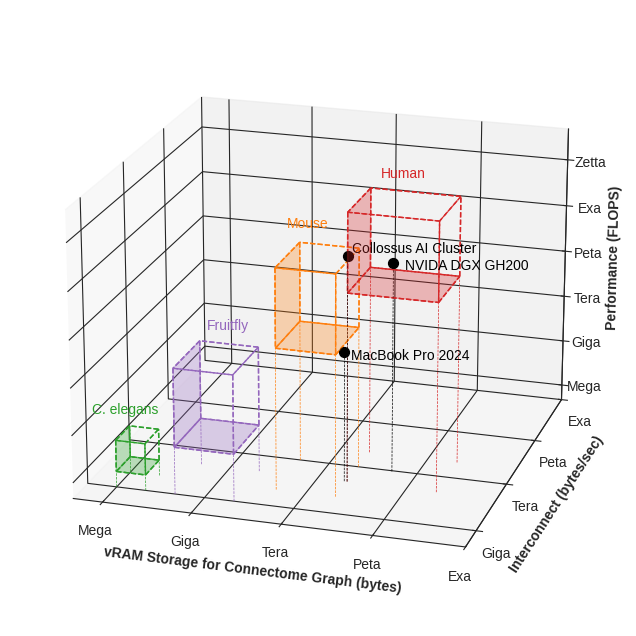

In [5]:
plt.close('all')

def create_box_vertices(x_min, x_max, y_min, y_max, z_min, z_max):
    vertices = np.array([
        [[x_min, y_min, z_min], [x_max, y_min, z_min], [x_max, y_max, z_min], [x_min, y_max, z_min]],  # bottom
        [[x_min, y_min, z_max], [x_max, y_min, z_max], [x_max, y_max, z_max], [x_min, y_max, z_max]],  # top
        [[x_min, y_min, z_min], [x_min, y_max, z_min], [x_min, y_max, z_max], [x_min, y_min, z_max]],  # left
        [[x_max, y_min, z_min], [x_max, y_max, z_min], [x_max, y_max, z_max], [x_max, y_min, z_max]],  # right
        [[x_min, y_min, z_min], [x_max, y_min, z_min], [x_max, y_min, z_max], [x_min, y_min, z_max]],  # back
        [[x_min, y_max, z_min], [x_max, y_max, z_min], [x_max, y_max, z_max], [x_min, y_max, z_max]]   # front
    ])
    return vertices

# Define min-z plane
z0 = 5

def draw_box(ax, vertices, color, label, label_pos):
    # Log scale
    vertices = np.log10(vertices)
    label_pos = np.log10(label_pos)
    
    # Draw only bottom and side faces
    which_faces = np.array([0, 2])
    faces = Poly3DCollection(vertices[which_faces], alpha=0.3)
    faces.set_facecolor(color)
    faces.set_edgecolor(color)
    ax.add_collection3d(faces)
    
    # Draw all edges
    for face in vertices:
        for i in range(4):
            start = face[i]
            end = face[(i + 1) % 4]
            ax.plot([start[0], end[0]], 
                   [start[1], end[1]], 
                   [start[2], end[2]], 
                   color=color,
                   linestyle='--',
                   linewidth=1)
    
    # Draw vertical lines to z=0
    for corner in vertices[0]:
        ax.plot([corner[0], corner[0]], 
               [corner[1], corner[1]], 
               [z0, corner[2]], 
               color=color, 
               linestyle='--', 
               linewidth=0.5)
    
    ax.text(label_pos[0], label_pos[1], label_pos[2], label, color=color)

# Create figure and 3D axes
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Define and draw boxes
boxes = [
    {
        'storage': [1e6, 1e7],
        'interconnect': [1e9, 1e10],
        'compute': [1e6, 1e8],
        'color': 'tab:green',
        'label': 'C. elegans',
        'label_pos': (7e4, 5e9, 6e8)
    },
    {
        'storage': [1e8, 1e10],
        'interconnect': [1e9, 1e11],
        'compute': [1e8, 1e13],
        'color': 'tab:purple',
        'label': 'Fruitfly',
        'label_pos': (5e8, 1e10, 5e14)
    },
    # {
    #     'storage': [1e8, 1e10],
    #     'interconnect': [1e9, 1e11],
    #     'compute': [1e8, 1e13],
    #     'color': 'tab:blue',
    #     'label': 'Zebrafish larvae',
    #     'label_pos': (5e13, 1e12, 3e23)
    # },
    {
        'storage': [1e11, 1e13],
        'interconnect': [1e10, 1e12],
        'compute': [1e14, 1e19],
        'color': 'tab:orange',
        'label': 'Mouse',
        'label_pos': (1e11, 1e11, 5e20)
    },
    {
        'storage': [1e13, 1e16],
        'interconnect': [1e11, 1e13],
        'compute': [1e17, 1e22],
        'color': 'tab:red',
        'label': 'Human',
        'label_pos': (5e13, 1e12, 3e23)
    },
]

for box in boxes:
    vertices = create_box_vertices(
        *box['storage'], 
        *box['interconnect'], 
        *box['compute'])
    draw_box(ax, vertices, box['color'], box['label'], box['label_pos'])

# Add points with labels and vertical lines
points = [
    {'storage': 8e12, 'interconnect': 1e11, 'compute': 2e13, 'label': 'MacBook Pro 2024', 'label_offset': [0.3,-0.2,-0.3]},
    {'storage': 1.44e14, 'interconnect': 9e11, 'compute': 2e18, 'label': 'NVIDA DGX GH200', 'label_offset': [0.5,-0.3,-0.1]},
    {'storage': 1e13, 'interconnect': 1e11, 'compute': 2e19, 'label': 'Collossus AI Cluster',}
]

for point in points:
    # Use log scale
    x = np.log10(point['storage'])
    y = np.log10(point['interconnect'])
    z = np.log10(point['compute'])
    
    ax.scatter([x], [y], [z], color='black', s=50)
    label_offset = point['label_offset'] if 'label_offset' in point else [0.1, 0.1, 0.1]
    ax.text(x + label_offset[0], y + label_offset[1], z + label_offset[2], point['label'], color='black')
    ax.plot([x, x], [y, y], [z0, z], color='black', linestyle='--', linewidth=0.5)

# Set axis labels and limits
ax.set_xlim(5, 18)
ax.set_ylim(8, 15)
ax.set_zlim(z0, 23)

ax.set_xlabel('vRAM Storage for Connectome Graph (bytes)', weight='bold')
ax.set_ylabel('Interconnect (bytes/sec)', weight='bold')
ax.set_zlabel('Performance (FLOPS)', weight='bold')

ax.set_xticks([6, 9, 12, 15, 18])
ax.set_xticklabels(['Mega', 'Giga', 'Tera', 'Peta', 'Exa'])

ax.set_yticks([9, 12, 15, 18])
ax.set_yticklabels(['Giga', 'Tera', 'Peta', 'Exa'])

ax.set_zticks([6, 9, 12, 15, 18, 21])
ax.set_zticklabels(['Mega', 'Giga', 'Tera', 'Peta', 'Exa', 'Zetta'])

# My axis should display 10⁻¹ but you can switch to e-notation 1.00e+01
def log_tick_formatter(val, pos=None):
    return f"$10^{{{int(val)}}}$"  # remove int() if you don't use MaxNLocator
    # return f"{10**val:.2e}"      # e-Notation

# ax.zaxis.set_major_formatter(mticker.FuncFormatter(log_tick_formatter))
# ax.zaxis.set_major_locator(mticker.MaxNLocator(integer=True))

# Adjust view angle
ax.view_init(elev=20, azim=-73)

plt.tight_layout()
add_attribution()
plt.savefig('third-drafts/organism-compute.png')
plt.show()

In [6]:
# Organism parallel coordinate

# Radar charts

In [7]:
neuro_sim_df = pd.read_csv('./data/Overview of Neuron Simulations - T3 - Simulations.csv')
neuro_sim_df.head()

organisms = ['C. elegans', 'Drosophila', 'Zebrafish', 'Mouse', 'Human']
neuro_sim_df = neuro_sim_df[neuro_sim_df['Organism'].isin(organisms)]
data_columns = [
    'Connectivity accuracy',
    'Percentage of neurons',
    'Neurontypes',
    'Plasticity',
    'Functional Accuracy',
    'Neuromodulation',
    'Temporal resolution',
    'Behavior',
    'Personality-defining Characteristics',
    'Learning',
]

# Drop this study with no data values (all values are '-')
neuro_sim_df.drop(neuro_sim_df[neuro_sim_df['First Author'] == 'Frye, Ananthanarayanan et al.'].index, inplace=True)

# Drop any other rows with missing data
neuro_sim_df.dropna(subset=data_columns, inplace=True)


# data_columns = neuro_sim_df.columns[-9:]
column_labels = [
    'Neuro-\nmodulation'
    if col == 'Neuromodulation'
    else textwrap.fill(col, 15, break_long_words=False)
    for col in data_columns
]

C. elegans


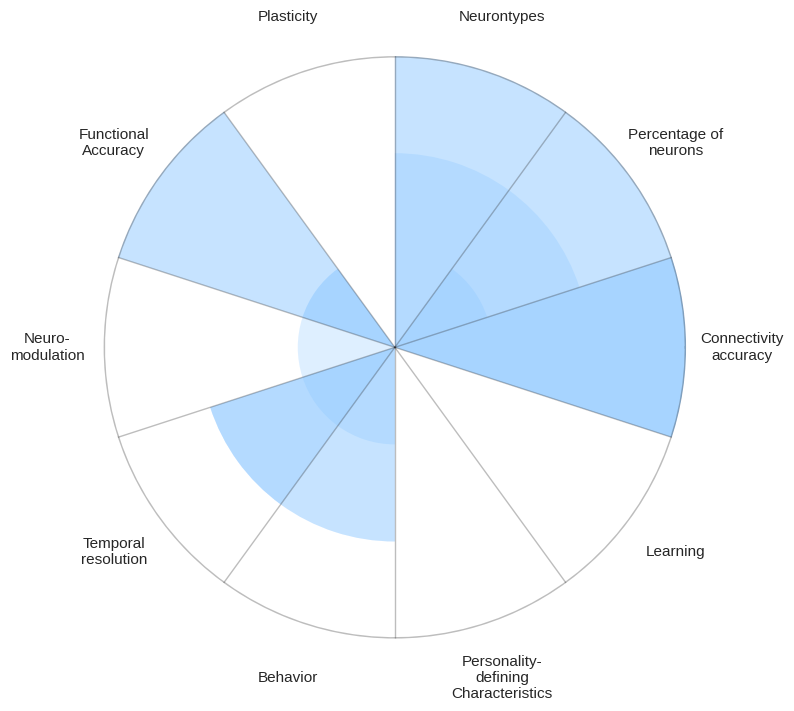

Drosophila


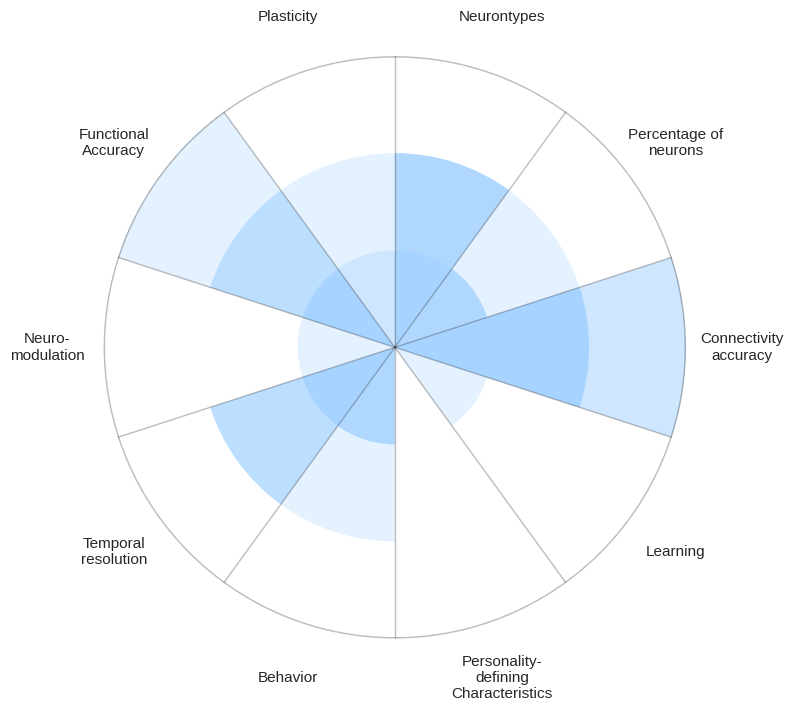

Zebrafish


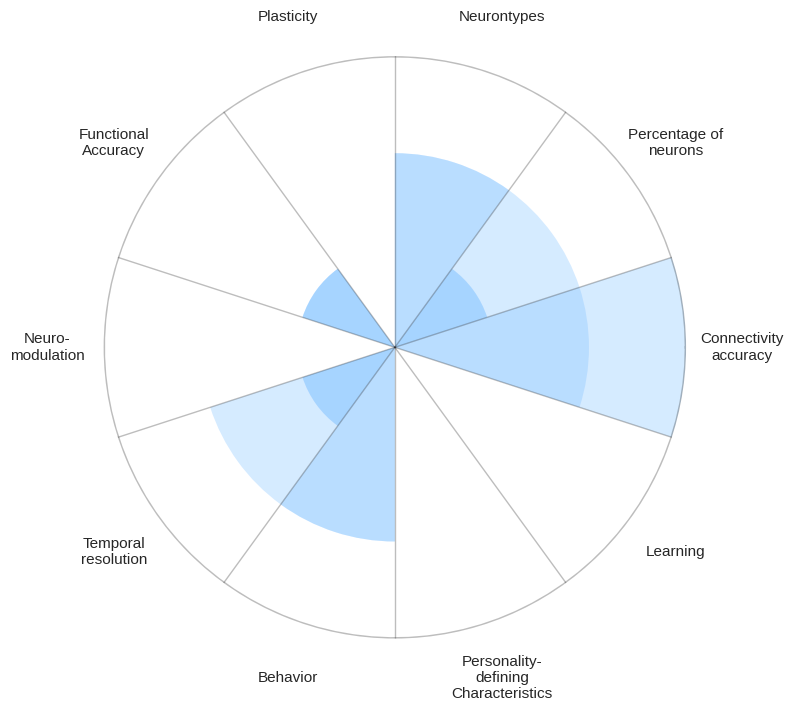

Mouse


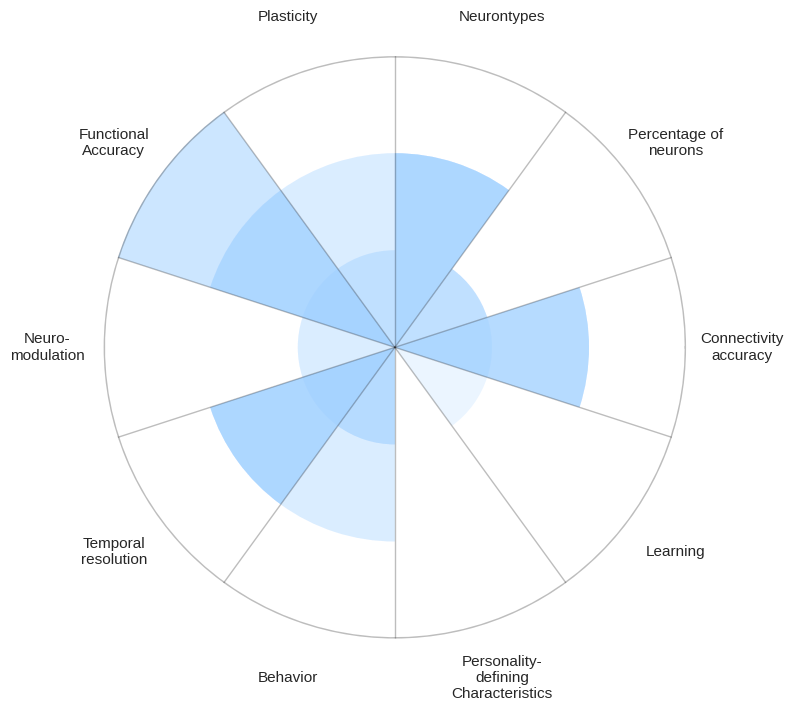

Human


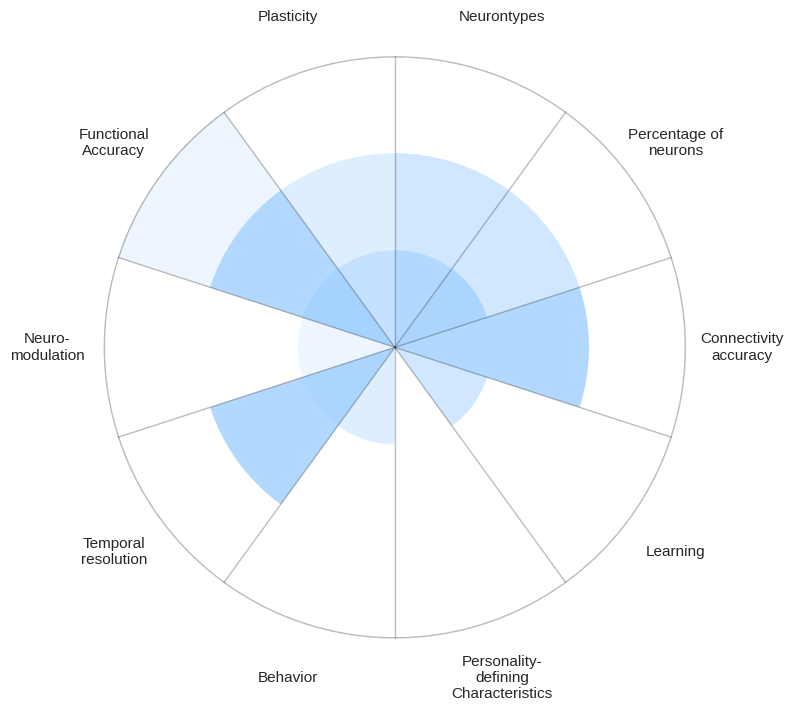

In [8]:
def sim_fig(ax, organism_df, individual_studies=None):
    # Number of categories
    N = len(column_labels)

    # Angles: equally spaced around the circle
    angles = np.linspace(0, 2 * np.pi, N, endpoint=False)

    # Each wedge gets the same width
    width = 2 * np.pi / N

    # Plot circle indicating maximum value
    theta = np.linspace(0, 2*np.pi, 100)
    ax.plot(
        theta, 
        [3]*100,
        color=COLOR_PALETTE['dividers'],
        # linestyle='--', 
        # alpha=0.5,
        lw=2,
    )

    # Draw radial dividers
    for i in range(N):
        theta_div = 2*np.pi * (i-1/2) / N
        ax.plot(
            [theta_div, theta_div], 
            [0, 3], 
            color=COLOR_PALETTE['dividers'],
            lw=1,
        )

    num_simulations = len(organism_df)
    base_alpha = 0.7  # adjust this value to change overall darkness
    
    # proper normalization - transparent colors don't add linearly
    normalized_alpha = 1 - (1 - base_alpha)**(1/num_simulations)

    legend_patches = []

    for k, (_, row) in enumerate(organism_df.iterrows()):
        try:
            values = row[data_columns].astype(float).values
        except ValueError:
            # skip rows with non-floats
            continue

        # Plot bars on polar axis
        bars = ax.bar(
            x=angles,
            height=values,
            width=width,
            bottom=0.0,
            alpha=normalized_alpha,  # now normalized by number of simulations
            color=COLOR_PALETTE['deepsky_blue'],
            edgecolor='none'
        )

        max_offset = 3
        offset = max_offset*np.random.rand()
        remainder = max_offset - offset
        dash_pattern = (offset, (1, 2))
        lw = 6
        color = f'C{k}'
        label = row['First Author']
        
                
        if individual_studies == 'polygon':
            # standard radar chart
            ax.plot(
                np.concatenate([angles, angles[:1]]),
                np.concatenate([values, values[:1]]),
                # alpha=normalized_alpha,  # now normalized by number of recordings
                # color=COLOR_PALETTE['bittersweet'],
                lw=lw,
                ls=dash_pattern,
                # dashes=[4,4],
                # facecolor='none',
                color=color,
                # label=row['First author'],
                clip_on = None,
            )

        if individual_studies is not None:
            legend_patches.append(Patch(color=color, label=label))
            
    if individual_studies is not None:
        plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1,1))

    # Set the category labels around the circle
    ax.set_xticks(angles)
    ax.set_xticklabels(column_labels, fontsize=11, color=COLOR_PALETTE['black'])

    # Remove radial lines & spines
    ax.set_yticks([])
    ax.grid(False)
    ax.spines['polar'].set_visible(False)
    ax.tick_params(axis='x', pad=30)  # increase the number 50 to move labels even further out
    
    # Set maximum radius
    ax.set_ylim(0, 3)

# For each organism, create one plot showing all simulations
for organism in organisms:
    print(organism)
    organism_df = neuro_sim_df[neuro_sim_df['Organism'] == organism]

    
    if organism_df.empty:
        print(f"No data for {organism}, skipping.")
        continue

    
    for individual_studies in [None]:
        # Set up polar bar chart
        fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    
        sim_fig(ax, organism_df, individual_studies=individual_studies)
     
    
        # Make layout look a bit better
        plt.tight_layout()
        suffix = "" if individual_studies is None else f"-{individual_studies}"
        add_attribution()
        plt.savefig(f'./fifth-drafts/neuro-sim/{organism}{suffix}.svg')
        plt.show()

# Functional data figure

In [9]:
neuro_rec_df = pd.read_csv('./data/Neurodynamics recording papers - Papers.csv')
neuro_rec_df.head()

,First author,Year,DOI/Link,Organism,Fixated / moving,Method,Number of neurons,Temporal resolution: Hz,Duration single session min,Duration total repeated sessions min,Resolution in µm isotropic,Individuals studied,Brain volume dimensions,SNR,Perturbation
0,Kato,2015,[10],C. elegans,fixated,Calcium,127,1.0,15.0,120.0,1,12.0,NaN,NaN,NaN
1,Nichols,2017,[12],C. elegans,fixated,Calcium,108,1.0,15.0,120.0,1,44.0,NaN,NaN,NaN
2,Skora,2018,[15],C. elegans,fixated,Calcium,129,1.0,15.0,120.0,1,12.0,NaN,NaN,NaN
3,Kaplan,2020,[9],C. elegans,fixated,Calcium,114,1.0,15.0,120.0,1,19.0,NaN,NaN,NaN
4,Yemini,2021,[37],C. elegans,fixated,Calcium,125,1.0,15.0,120.0,1,49.0,NaN,NaN,NaN


In [10]:
# rename zebrafish to match sim df
neuro_rec_df.replace('Zebrafish Larvae', 'Zebrafish', inplace=True)

In [11]:
def oom_transform(x, oom_range):
    min_oom, max_oom = oom_range
    if abs(max_oom - min_oom) != 5:
        raise ValueError("Must span 5 orders of magnitude")
    # Reverse axis direction if range is given backwards
    if min_oom < max_oom:
        return max(np.log10(x) - min_oom, 0)
    else:
        max_oom, min_oom = oom_range
        return max(max_oom - np.log10(x), 0)

In [12]:
def get_ooms(oom_range):
    return np.linspace(*oom_range, num=6, endpoint=True).astype(int)[1:]

In [13]:
organism_neuro_df = pd.read_csv('./data/Neurodynamics recording papers - Organisms.csv')
organism_neuro_df.replace('Zebrafish Larvae', 'Zebrafish', inplace=True)
organism_neuro_df.replace('C. Elegans', 'C. elegans', inplace=True)
organism_neuro_df.index = organism_neuro_df.loc[:, 'Organism']
organism_neuro_df.drop(columns=['Organism'], inplace=True)

organism_neuro_df

,Total Neuron Count,Maximum Neuron Firing Rate (Hz),Average Liftime in Minutes,Isotropic resolution Single Neuron recording in µm
Organism,,,,
C. elegans,302,10,21600,1
Zebrafish,100000,80,14400,1
Drosophila,140000,200,57600,1
Mouse,70000000,200,1576800,1
Human,87000000000,415,39420000,1


In [14]:
# Define 5 OOM axes ranges for each organism
neuro_rec_max_props = {
    'Number of neurons': {
        'col': 'Total Neuron Count',
        'short': 'Total Neurons',
    },
    'Temporal resolution: Hz': {
        'col': 'Maximum Neuron Firing Rate (Hz)',
        'short': 'Max. Neuron Firing Rate',
        'units': 'Hz',
    },
    'Duration single session min': {
        'col': 'Average Liftime in Minutes',
        'short': 'Avg. Lifetime',
        'units': 'min',
    },
    'Duration total repeated sessions min': {
        'col': 'Average Liftime in Minutes',
        'short': 'Avg. Lifetime',
        'units': 'min',
    },
    'Resolution in µm isotropic': {
        'col': 'Isotropic resolution Single Neuron recording in µm',
        'short': 'Single Neuron Resolution',
        'units': 'µm³',
    },
}

# Reverse these axes because lower is better
neuro_rec_rev_axes = ['Resolution in µm isotropic']

neuro_rec_data_columns = list(neuro_rec_max_props.keys())
neuro_rec_column_labels = [
    textwrap.fill(col, 15, break_long_words=False)
    for col in neuro_rec_data_columns
]

neuro_rec_ax_max_oom = {
    organism: {
        col: (np.ceil 
              if col in neuro_rec_rev_axes 
              else np.floor)(np.log10(
            organism_neuro_df.loc[
                organism, 
                neuro_rec_max_props[col]['col']
            ]
        ))
        for col in neuro_rec_data_columns
    }
    for organism in organisms
}


neuro_rec_ax_oom_ranges = {
    organism: {
        col: [
            neuro_rec_ax_max_oom[organism][col] + 5,
            neuro_rec_ax_max_oom[organism][col],
        ] 
        if col in neuro_rec_rev_axes
        else [
            neuro_rec_ax_max_oom[organism][col] - 5,
            neuro_rec_ax_max_oom[organism][col],
        ]
        for col in neuro_rec_data_columns
    }
    for organism in organisms
}

In [15]:
# Filter out rows with missing data
neuro_rec_df.dropna(subset=neuro_rec_data_columns + ['Organism'], inplace=True)

In [16]:
def format_exp_float(x, bold=False):
    expnt = int(np.floor(np.log10(x)))
    base = x / 10**expnt
    inner = rf"{base:.1f} \times 10^{{{expnt}}}"
    if bold:
        return rf"$\mathbf{{{inner}}}$"
    else:
        return f"${inner}$"

C. elegans/fixated


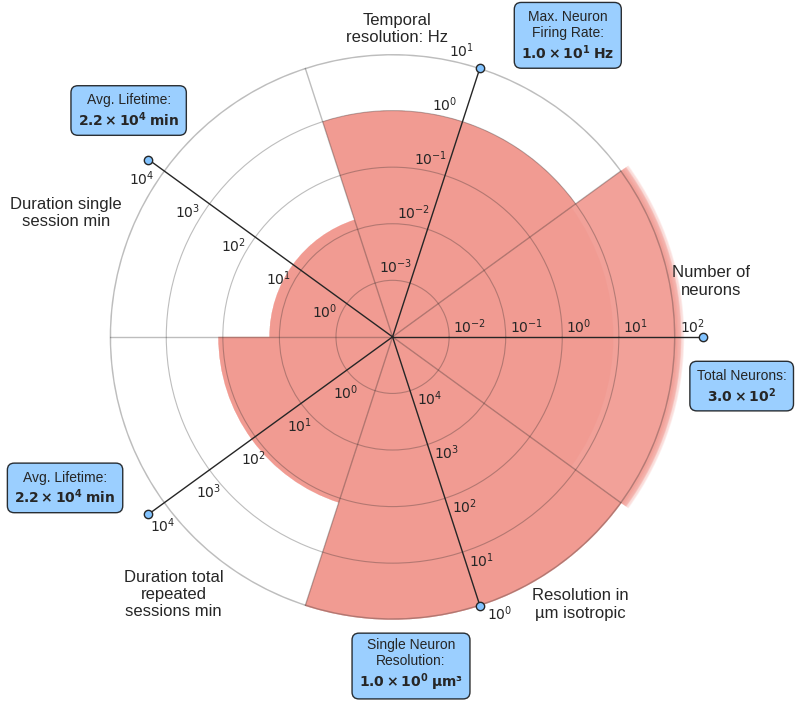

C. elegans/moving


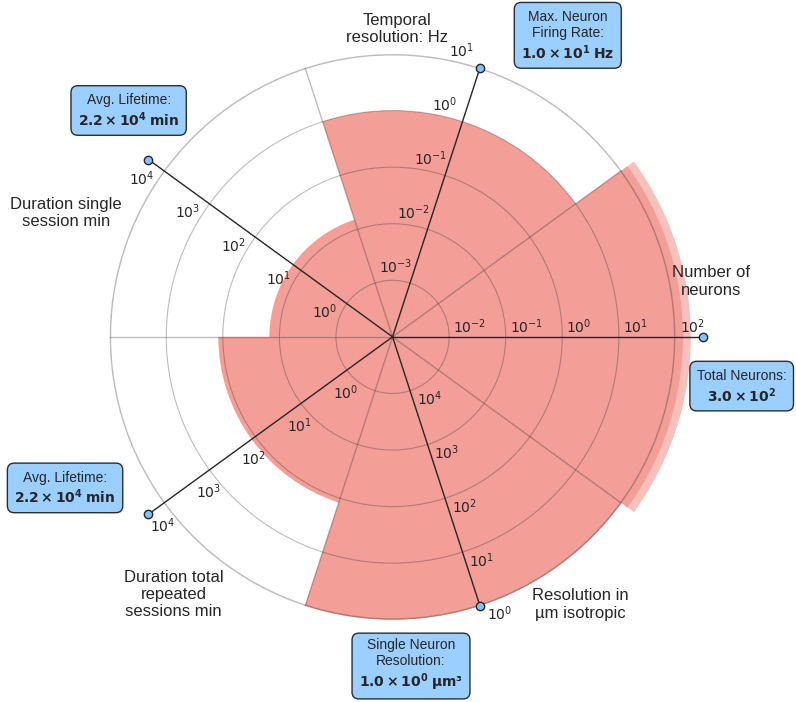

Drosophila/fixated


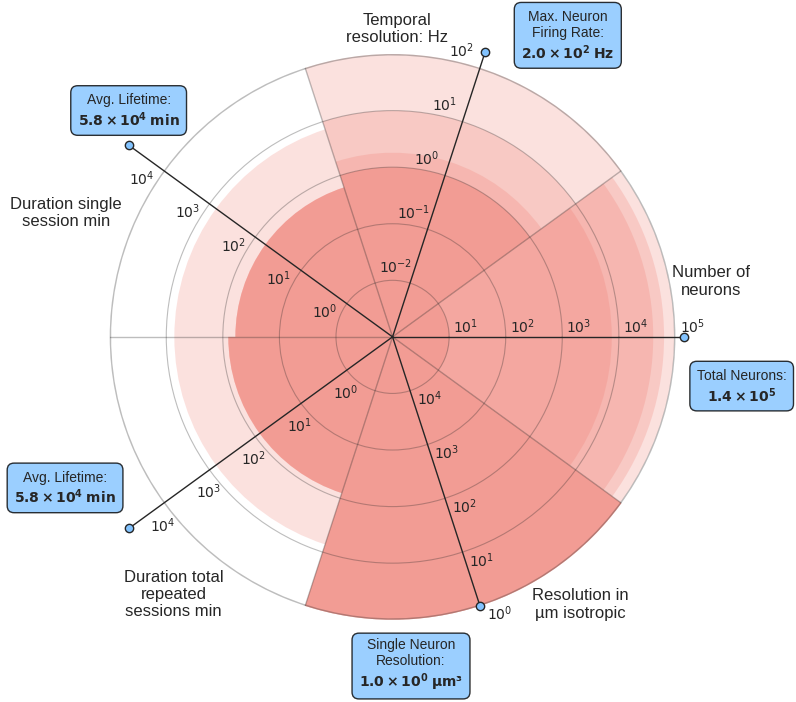

No data for Drosophila/moving, skipping.
Zebrafish/fixated


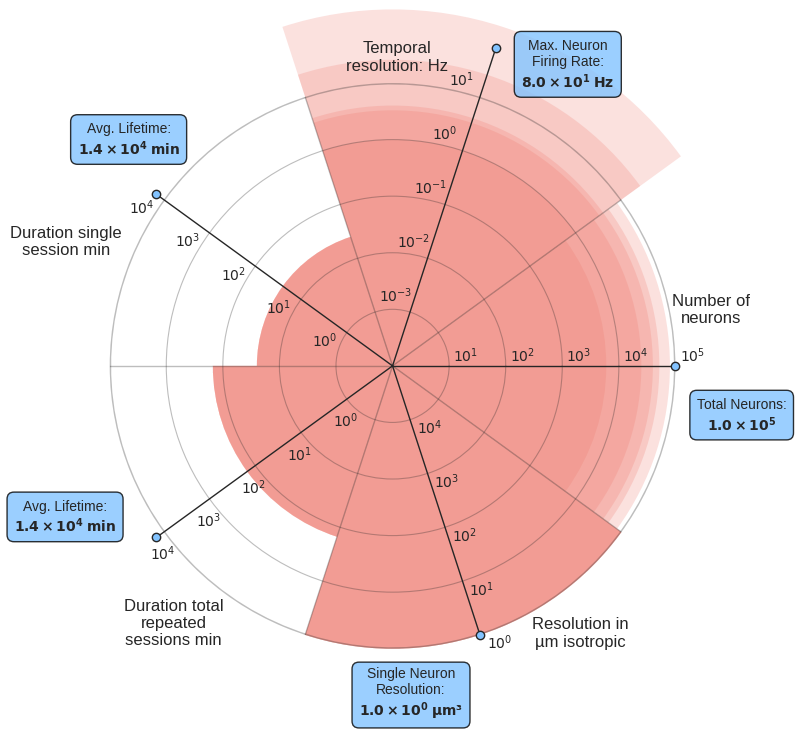

No data for Zebrafish/moving, skipping.
Mouse/fixated


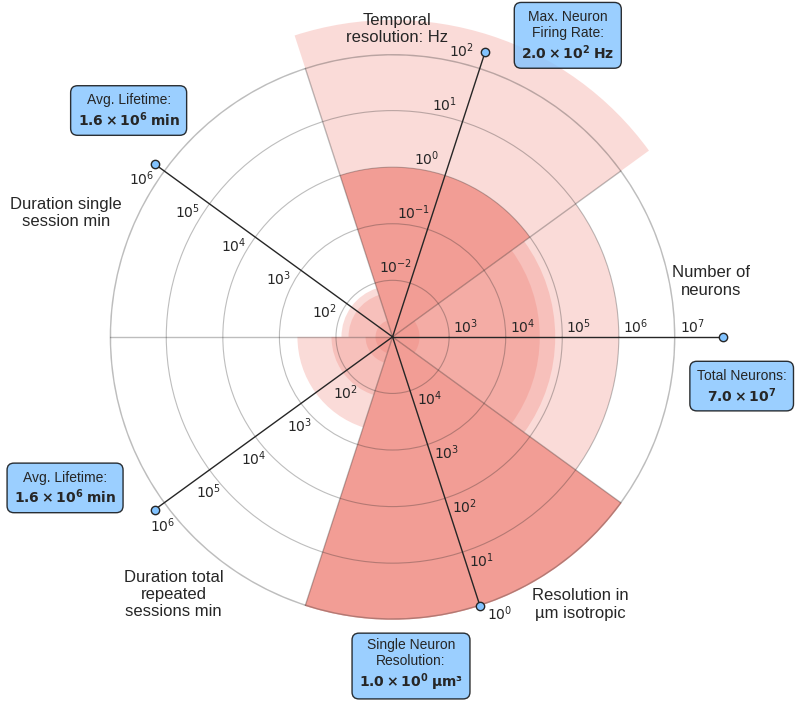

Mouse/moving


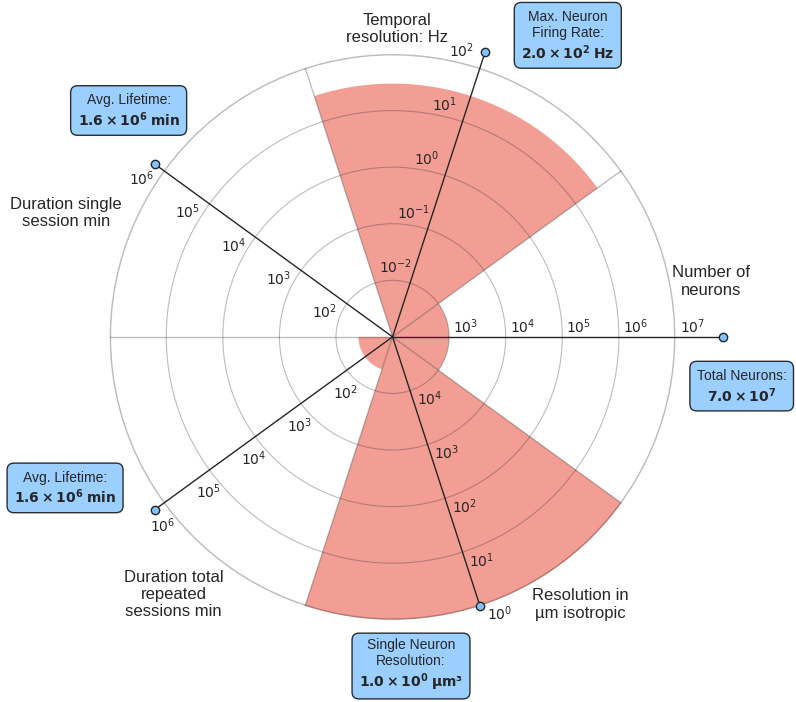

Human/fixated


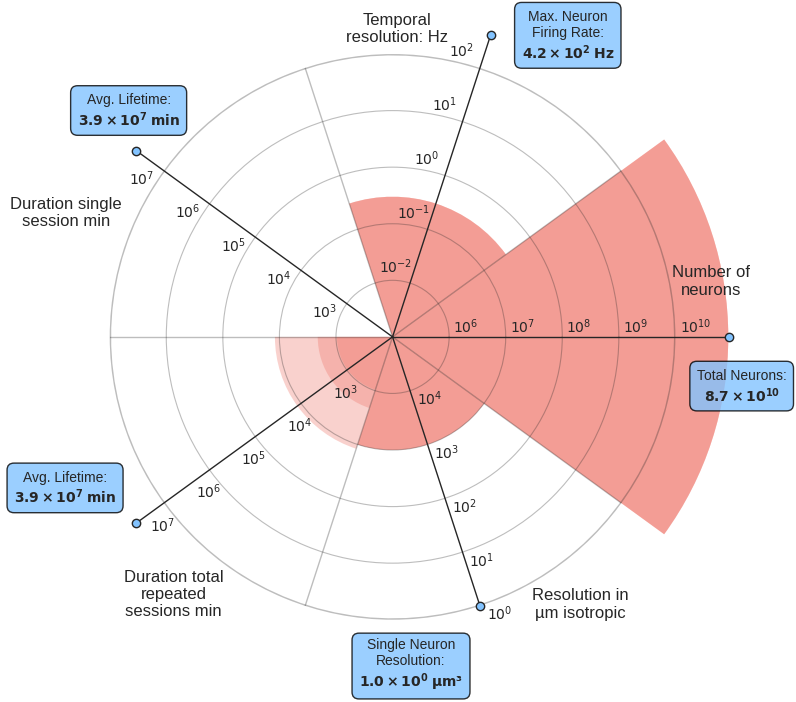

No data for Human/moving, skipping.


In [17]:
def rec_fig(ax, sub_df, individual_studies=None):
    N = 5
    
    # Angles: equally spaced around the circle
    angles = np.linspace(0, 2 * np.pi, N+1)
    unique_angles = angles[:-1]

    # Each wedge gets the same width
    width = 2 * np.pi / N

    # Plot circle indicating maximum value
    theta = np.linspace(0, 2*np.pi, 100)
    ax.plot(
        theta, 
        [5]*100,
        color=COLOR_PALETTE['dividers'],
        # linestyle='--', 
        # alpha=0.5,
        lw=2,
    )
    
    tick_offsets = [
        [3, 3],
        [-22, 8],
        [-25,-10],
        [-10,-20],
        [5,-10],
    ]
    
    # Add tick labels for each section
    for i, col_name in enumerate(neuro_rec_data_columns):
        theta = 2*np.pi * i / N
        oom_range = neuro_rec_ax_oom_ranges[organism][col_name]
        ooms = get_ooms(oom_range)
        for j, expnt in enumerate(ooms):
            label = f'$10^{{{expnt}}}$'
            r = j + 1
            ax.annotate(
                label, 
                (theta, r),
                xytext=tick_offsets[i],
                textcoords='offset points',
                color=COLOR_PALETTE['black']
            )
            


    # label_offsets = [
    #     [10,10],
    #     [-50,10],
    #     [10,10],
    #     [10,10],
    #     [10,10],
    # ]   

    # Draw radial axes
    for i, theta_ax in enumerate(unique_angles):
        col_name = neuro_rec_data_columns[i]
        max_val = organism_neuro_df.loc[
            organism, 
            neuro_rec_max_props[col_name]['col']
        ]
        oom_range = neuro_rec_ax_oom_ranges[organism][col_name]
        oom_val = oom_transform(max_val, oom_range)
        ax.plot(
            [theta_ax, theta_ax], 
            [0, oom_val], 
            color=COLOR_PALETTE['black'],
            lw=1,
            clip_on=None, # draw outside the axes
            transform=ax.transData,
        )
             
        axis_label_offsets = [
            [30, 0],
            [-20,20],
            [-50,5],
            [-20,-35],
            [35,-15],
        ]    

        # # axis labels
        ax.annotate(
            neuro_rec_column_labels[i], 
            (theta_ax+0.2, 5),
            xytext=axis_label_offsets[i],
            # xytext=(0,0),
            fontsize=12,
            textcoords='offset points',
            color=COLOR_PALETTE['black'],
            ha='center',
            va='center',
        )
        
        # Label max val
        ax.plot(
            [theta_ax], 
            [oom_val], 
            'o', 
            color=COLOR_PALETTE['deepsky-blue'], 
            clip_on=None, # draw outside the axes
            mec=COLOR_PALETTE['black'],
            transform=ax.transData,
        )

        max_val_str = format_exp_float(max_val, bold=True)
            
        max_val_offsets = [
            [50,-5],
            [35,35],
            [-45,20],
            [-55,-15],
            [-20,-35],
        ]    

        max_desc = textwrap.fill(
            neuro_rec_max_props[col_name]['short'],
            15,
            break_long_words = False,
        )
        max_units = (
            rf" $\mathbf{{{neuro_rec_max_props[col_name]['units']}}}$"
            if 'units' in neuro_rec_max_props[col_name]
            else ''
        )
        max_label = f"{max_desc}:\n{max_val_str}{max_units}"
        ax.annotate(
            max_label, 
            (theta_ax-0.15, 5),
            xytext=max_val_offsets[i],
            # xytext=(0,0),
            textcoords='offset points',
            clip_on=False,
            bbox=dict(
                facecolor=COLOR_PALETTE['deepsky-blue'],
                alpha=0.8,
                edgecolor='black',
                boxstyle='round,pad=0.5'
            ),
            ha='center',
            va='center',
            color=COLOR_PALETTE['black'],
            # fontweight='bold'
        )
        
    # Draw section dividers
    for i in range(N):
        theta_div = 2*np.pi * (i-1/2) / N
        ax.plot(
            [theta_div, theta_div], 
            [0, 5], 
            color=COLOR_PALETTE['dividers'],
            lw=1,
        )

    legend_patches = []
    
    base_alpha = 0.7  # adjust this value to change overall darkness

    num_recs = len(sub_df)
    # proper normalization - transparent colors don't add linearly
    normalized_alpha = 1 - (1 - base_alpha)**(1/num_recs)

    for k, (j, row) in enumerate(sub_df.iterrows()):
        values = []
        for col_name in neuro_rec_data_columns:
            # transform to axis coordinates
            col_val = row[col_name]
            oom_range = neuro_rec_ax_oom_ranges[organism][col_name]
            oom_val = oom_transform(col_val, oom_range)
            values.append(oom_val)

        # Plot bars on polar axis
        # monochrome
        ax.bar(
            x=unique_angles,
            height=values,
            width=width,
            bottom=0.0,
            alpha=normalized_alpha,  # now normalized by number of recordings
            color=COLOR_PALETTE['bittersweet'],
            edgecolor='none',
            clip_on = None,
            # label=fixmov,
        )

        # distinguish each study
        
        max_offset = 3
        offset = max_offset*np.random.rand()
        remainder = max_offset - offset
        dash_pattern = (offset, (1, 2))
        lw = 6
        color = f'C{k}'
        label = row['First author']
        
        if individual_studies == 'pie':
            # "filled" radar chart (pie slices)
            ax.bar(
                x=unique_angles,
                height=values,
                width=width,
                bottom=0.0,
                # alpha=normalized_alpha,  # now normalized by number of recordings
                # color=COLOR_PALETTE['bittersweet'],
                lw=lw,
                ls=dash_pattern,
                clip_on=None,
                # dashes=[4,4],
                facecolor='none',
                edgecolor=color,
                # label=label,
            )
            
        elif individual_studies == 'polygon':
            # standard radar chart
            ax.plot(
                angles,
                np.concatenate([values, values[:1]]),
                # alpha=normalized_alpha,  # now normalized by number of recordings
                # color=COLOR_PALETTE['bittersweet'],
                lw=lw,
                ls=dash_pattern,
                # dashes=[4,4],
                # facecolor='none',
                color=color,
                # label=row['First author'],
                clip_on = None,
            )

        if individual_studies is not None:
            legend_patches.append(Patch(color=color, label=label))
            

    # Set the category labels around the circle
    # ax.set_xticks(
    #     unique_angles + 0.2, 
    #     labels=neuro_rec_column_labels, 
    #     fontsize=11, 
    #     color=COLOR_PALETTE['black'], 
    #     ha='center', 
    #     va='center'
    # )
    ax.set_xticks([])
    
    # increase the number 50 to move labels even further out
    ax.tick_params(axis='x', pad=35)

    # Remove radial lines & spines
    ax.set_yticks(range(5), labels=[])
    ax.grid(axis='x', visible=False)
    ax.grid(
        axis='y', 
        color=COLOR_PALETTE['dividers_rgb'],
        alpha=COLOR_PALETTE['dividers_alpha'],
    )
    ax.spines['polar'].set_visible(False)

    # Set maximum radius
    ax.set_ylim(0, 5)

    # Draw legend if necessary
    if individual_studies is not None:
        plt.legend(handles=legend_patches, loc='upper left', bbox_to_anchor=(1, 1))


# Whether to plot each study in a different color
individual_studies = True

for organism in organisms:
    organism_df = neuro_rec_df[neuro_rec_df['Organism'] == organism]

    # colors = [
    #     COLOR_PALETTE['deepsky-blue'],
    #     COLOR_PALETTE['bittersweet'],
    # ]
    
    # For each organism, create one plot showing all simulations
    for i, fixmov in enumerate(['fixated', 'moving']):
        sub_df = organism_df[organism_df['Fixated / moving'] == fixmov]
        
        if sub_df.empty:
            print(f"No data for {organism}/{fixmov}, skipping.")
            continue

        print(f"{organism}/{fixmov}")

        for individual_studies in [None]:
            # Set up polar bar chart
            fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
            rec_fig(
                ax,
                sub_df, 
                individual_studies=individual_studies
            )
        
            # Make layout look a bit better
            plt.tight_layout()
    
            suffix = "" if individual_studies is None else f"-{individual_studies}"
            add_attribution()
            plt.savefig(f'./fifth-drafts/neuro-rec/{organism}-{fixmov}{suffix}.svg')
            plt.show()

# All sim/rec charts together

i=0
C. elegans/fixated
C. elegans/moving
i=1
Drosophila/fixated
No data for Drosophila/moving, skipping.
i=2
Zebrafish/fixated
No data for Zebrafish/moving, skipping.
i=3
Mouse/fixated
Mouse/moving
i=4
Human/fixated
No data for Human/moving, skipping.


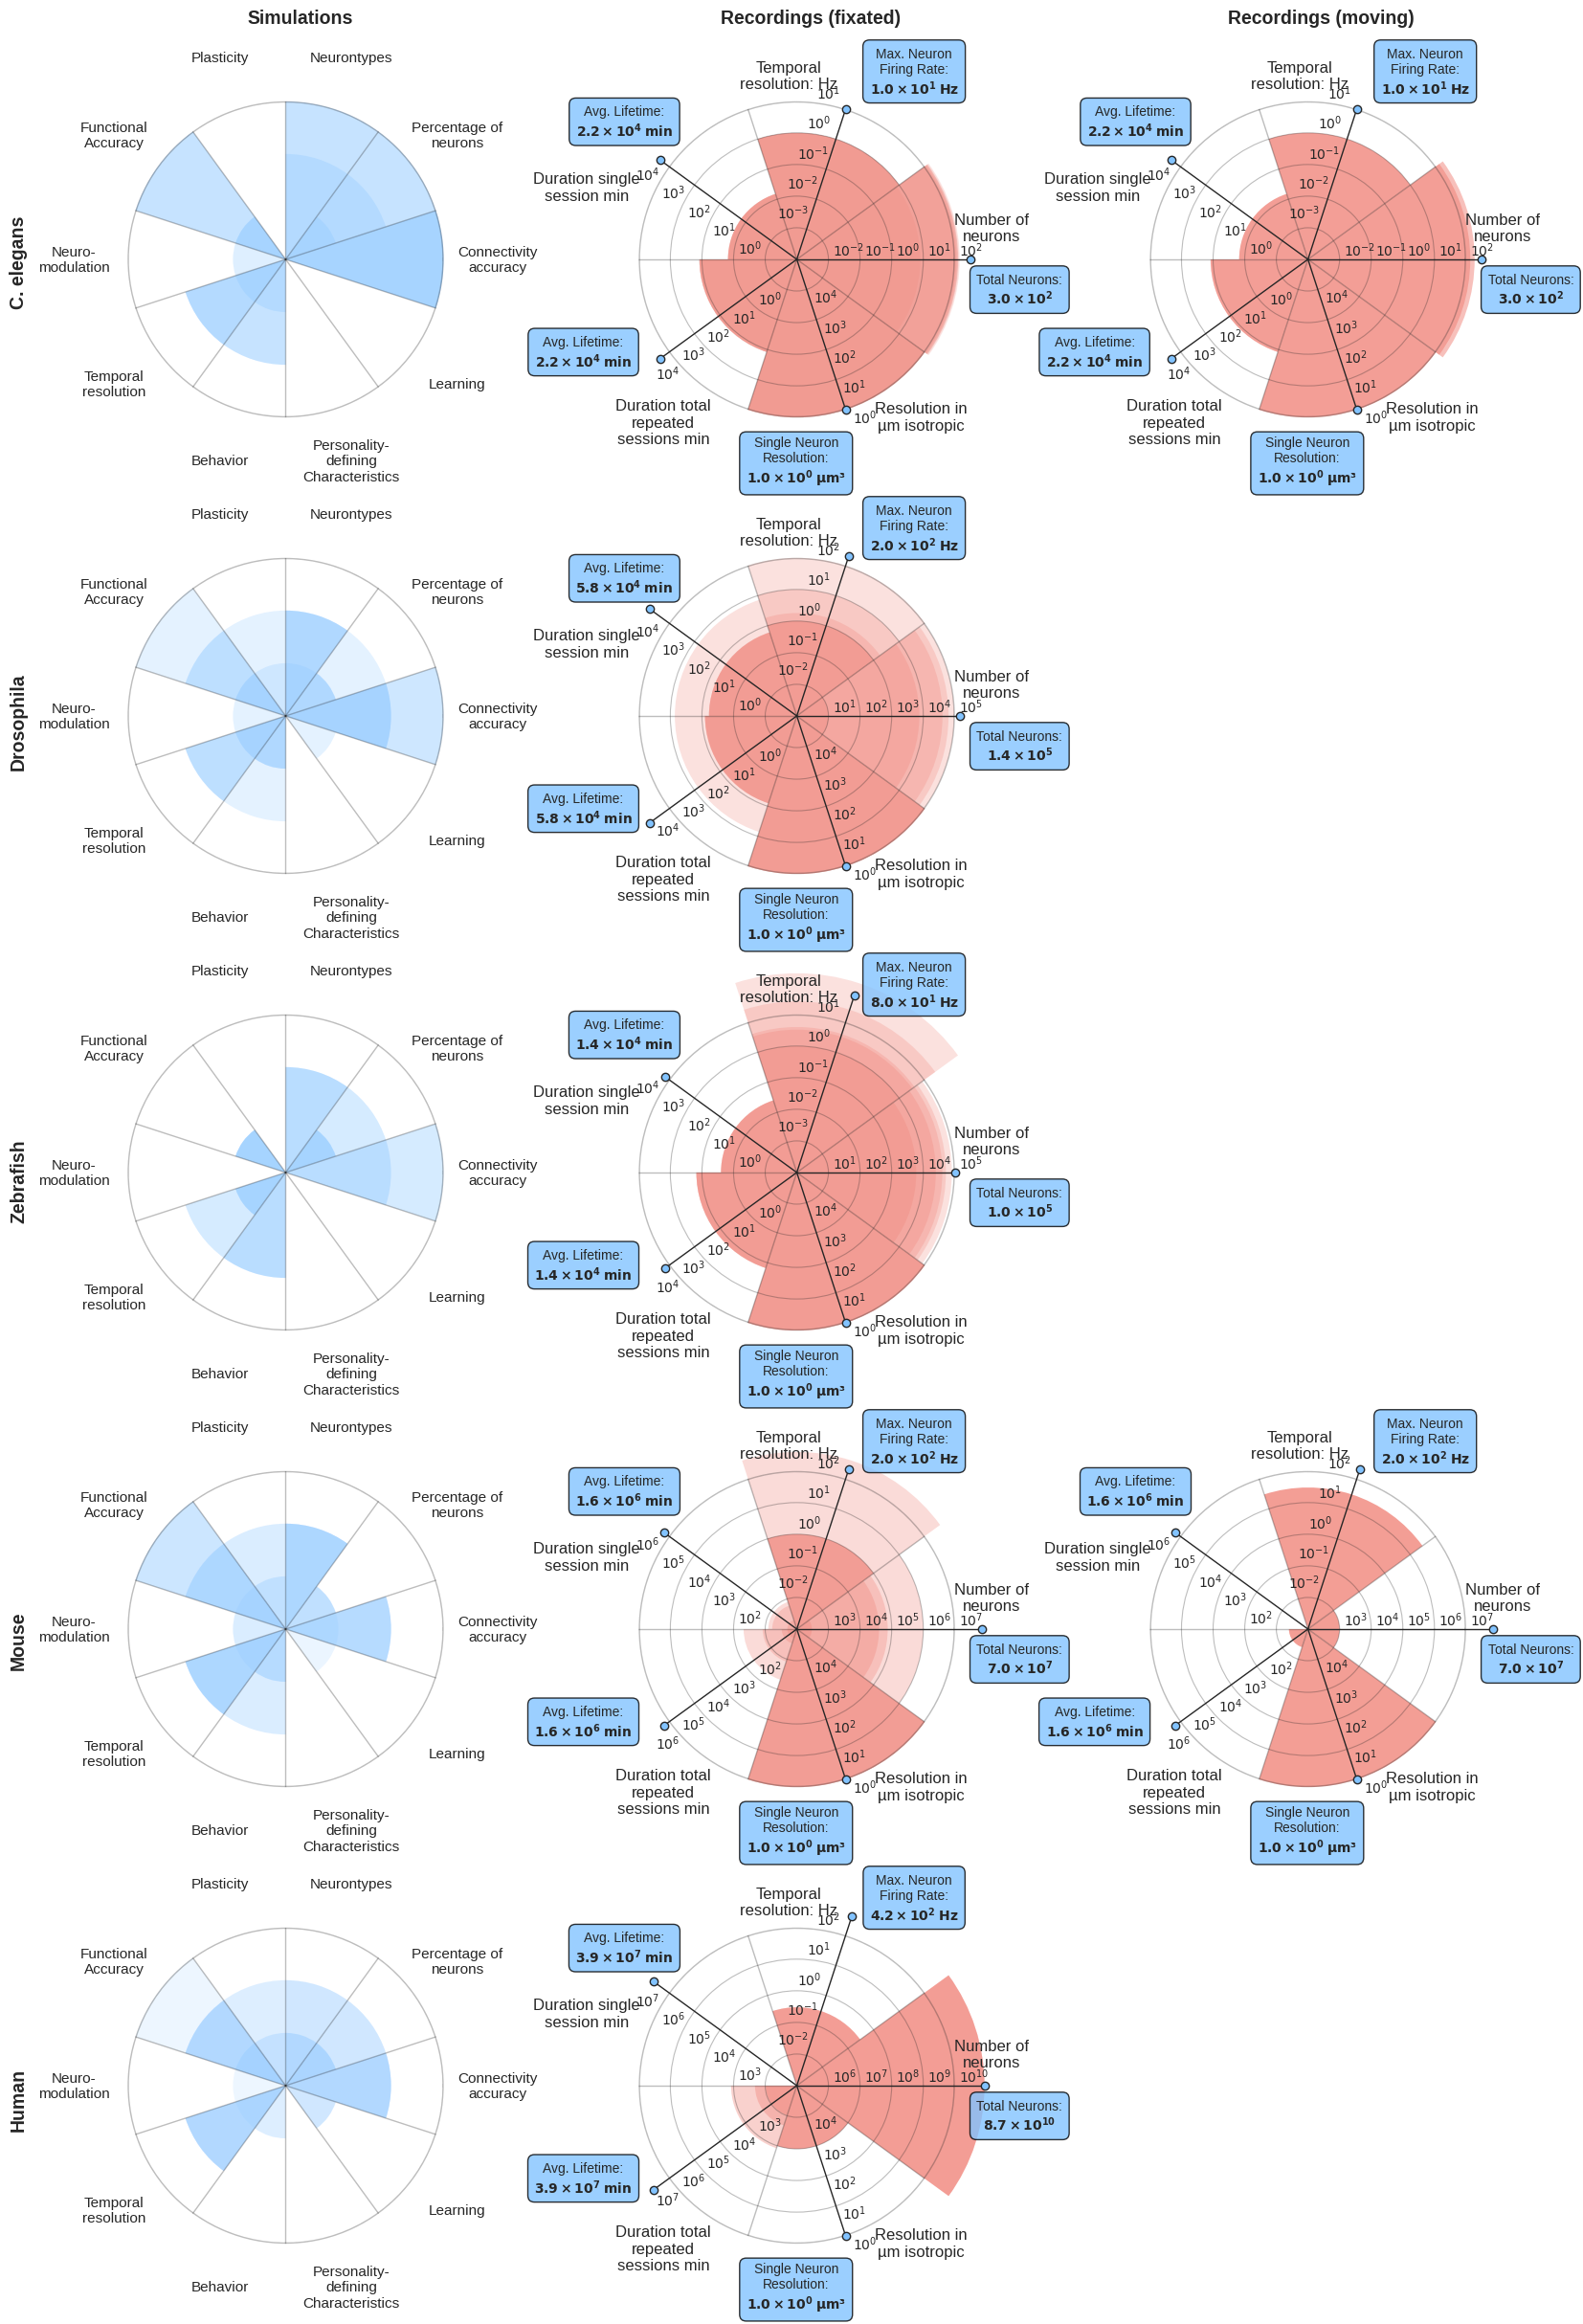

In [18]:
fig, axs = plt.subplots(5, 3, figsize=(16, 24), subplot_kw=dict(polar=True))

for i, organism in enumerate(organisms):
    print(f"i={i}")
    organism_rec_df = neuro_rec_df[neuro_rec_df['Organism'] == organism]
    organism_sim_df = neuro_sim_df[neuro_sim_df['Organism'] == organism]

    sim_fig(axs[i,0], organism_sim_df)
    
    # For each organism, create one plot showing all simulations
    for j, fixmov in enumerate(['fixated', 'moving']):
        sub_df = organism_rec_df[organism_rec_df['Fixated / moving'] == fixmov]
        
        if sub_df.empty:
            print(f"No data for {organism}/{fixmov}, skipping.")
            fig.delaxes(axs[i, j+1])
            continue

        print(f"{organism}/{fixmov}")

        # Number of categories
        N = len(neuro_rec_column_labels)
        
        rec_fig(axs[i, j+1], sub_df)

# Add row labels using text on the figure
row_labels = organisms
for i, label in enumerate(row_labels):
    fig.text(
        -0.02, 
        1 - (i+0.5)/5, 
        label, 
        rotation=90,
        va='center',
        fontweight='bold',
        fontsize=14,
    )

# Add column labels
col_labels = ['Simulations', 'Recordings (fixated)', 'Recordings (moving)']
for j, label in enumerate(col_labels):
    fig.text(
        0.17 + j/3,
        1.01, 
        label, 
        ha='center',
        va='top',
        fontweight='bold',
        fontsize=14,
    )

# Make layout look a bit better
plt.tight_layout()
add_attribution()
plt.savefig(f'./fifth-drafts/all-sim-rec.svg')
plt.show()

# Simulation Heatmaps

In [19]:
# Sort dataframe by organism
neuro_sim_df['Organism'] = pd.Categorical(neuro_sim_df['Organism'], categories=organisms, ordered=True)
neuro_sim_df.sort_values(['Organism', 'Year'], inplace=True)
# Reset index
neuro_sim_df.reset_index(drop=True, inplace=True)

In [20]:
# Get index ranges for each organism
neuro_sim_index_ranges = neuro_sim_df.groupby('Organism', observed=False).apply(lambda x: (x.index.min(), x.index.max()), include_groups=False)

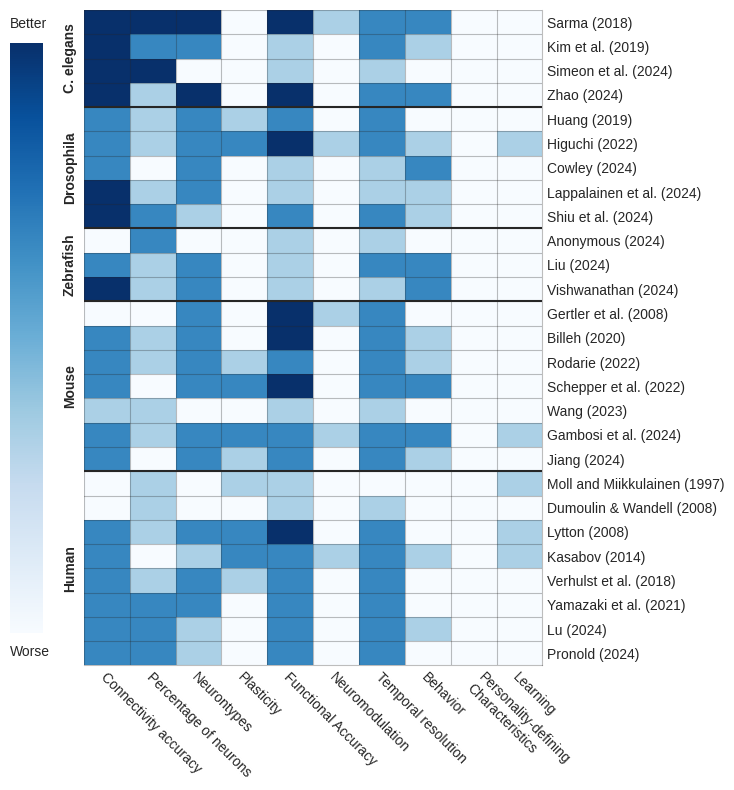

In [21]:
fig, sim_ax = plt.subplots(figsize=(8, 8))

shrink = 0.9

# Simulations
heatmap = sns.heatmap(
    neuro_sim_df[data_columns].astype(float),
    ax=sim_ax,
    cbar=True,
    cmap='Blues',
    cbar_kws=dict(
        orientation="vertical",
        location="left",
        # fraction=0.01,
        shrink=shrink,
        aspect=20*shrink,
        pad=0.07,
    ),
)

num_sims = len(neuro_sim_df)

cbar = heatmap.collections[0].colorbar

cbar.set_ticks([])
# cbar.ax.yaxis.tick_right()
cbar.ax.text(0, -0.02, "Worse", transform=cbar.ax.transAxes, 
             ha='left', va='top')
cbar.ax.text(0, 1.02, "Better", transform=cbar.ax.transAxes, 
             ha='left', va='bottom')

sim_ax.yaxis.tick_right()
sim_ax.set_xticks(
    np.arange(10) + 0,
    labels=[],
)
sim_ax.set_xticks(
    np.arange(10) + 0.3,
    [textwrap.fill(col, width=25) for col in data_columns],
    rotation=-45,
    ha='left',
    minor=True
)
sim_ax.set_yticks(
    np.arange(num_sims),
    labels=[],
)
sim_ax.set_yticks(
    np.arange(num_sims) + 0.5,
    # labels=neuro_sim_df['First Author'],
    labels=[
        f'{row['First Author']} ({int(row['Year'])})'
        for _, row in neuro_sim_df.iterrows()
    ],
    rotation=0,
    minor=True,
)

# TODO: Group by organism
for i, organism in enumerate(organisms):
    index_range = neuro_sim_index_ranges[organism]
    center = (index_range[1] + index_range[0]) / 2 + 0.5

    # Draw group label
    sim_ax.annotate(
        organism,
        (0, center),
        xytext=(-10, 0),
        textcoords='offset points',
        rotation=90,
        ha='center',
        va='center',
        fontweight='bold',
    )

    # Draw group boundary
    if i > 0:
        sim_ax.plot(
            [0, 14],
            [index_range[0], index_range[0]],
            color=COLOR_PALETTE['black'],
            # clip_on=None,
        )

# Don't actually draw any ticks
sim_ax.tick_params(axis='both', which='both', length=0)

# Add borders (seem to be missing by default because of tick labels)
for direction in ['bottom', 'right']:
    sim_ax.spines[direction].set_visible(True)
    sim_ax.spines[direction].set_color(COLOR_PALETTE['dividers'])

plt.grid()
plt.tight_layout()
add_attribution()
plt.savefig('./fifth-drafts/sim-heatmap.svg')
plt.show()

# Recordings Heatmap

In [22]:
# Sort dataframe by organism
neuro_rec_df['Organism'] = pd.Categorical(neuro_rec_df['Organism'], categories=organisms, ordered=True)
neuro_rec_df.sort_values(['Organism', 'Year'], inplace=True)
# Reset index
neuro_rec_df.reset_index(drop=True, inplace=True)

In [23]:
# Get index ranges for each organism
neuro_rec_index_ranges = neuro_rec_df.groupby('Organism', observed=False).apply(lambda x: (x.index.min(), x.index.max()), include_groups=False)

In [25]:
{
    col_name: {
        organism: organism_neuro_df.loc[
            organism,
            neuro_rec_max_props[col_name]['col']
        ]
        for organism in organisms
    }
    for col_name in neuro_rec_data_columns
}

{'Number of neurons': {'C. elegans': 302,
  'Drosophila': 140000,
  'Zebrafish': 100000,
  'Mouse': 70000000,
  'Human': 87000000000},
 'Temporal resolution: Hz': {'C. elegans': 10,
  'Drosophila': 200,
  'Zebrafish': 80,
  'Mouse': 200,
  'Human': 415},
 'Duration single session min': {'C. elegans': 21600,
  'Drosophila': 57600,
  'Zebrafish': 14400,
  'Mouse': 1576800,
  'Human': 39420000},
 'Duration total repeated sessions min': {'C. elegans': 21600,
  'Drosophila': 57600,
  'Zebrafish': 14400,
  'Mouse': 1576800,
  'Human': 39420000},
 'Resolution in µm isotropic': {'C. elegans': 1,
  'Drosophila': 1,
  'Zebrafish': 1,
  'Mouse': 1,
  'Human': 1}}

In [26]:
# Convert values to 5 OOM log-scale based on organism max values
neuro_rec_df_scaled = neuro_rec_df.copy()

for col_name in neuro_rec_data_columns:
    # Update dtypes
    neuro_rec_df_scaled[col_name] = neuro_rec_df_scaled[col_name].astype(float)

    for organism in organisms:
        max_val = organism_neuro_df.loc[
            organism,
            neuro_rec_max_props[col_name]['col']
        ]
        organism_df = neuro_rec_df_scaled[neuro_rec_df_scaled['Organism'] == organism]
        for i, row in organism_df.iterrows():
            log_val = np.log10(row[col_name])
            log_max = np.log10(max_val)
            scaled = log_max - log_val if col_name in neuro_rec_rev_axes else log_val - log_max
            neuro_rec_df_scaled.loc[i, col_name] = scaled

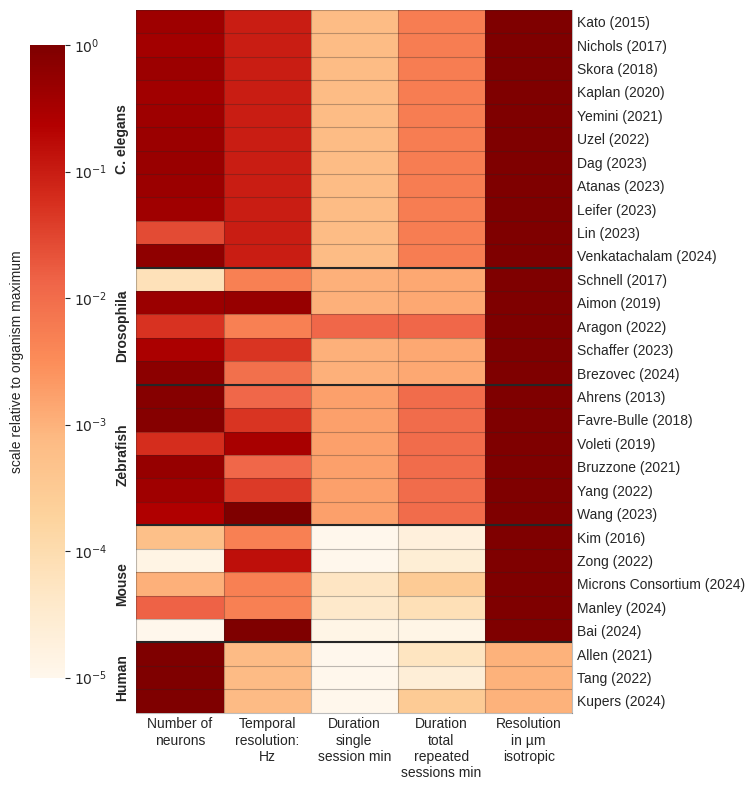

In [27]:
fig, rec_ax = plt.subplots(figsize=(8, 8))

shrink = 0.9

# Recordings
heatmap = sns.heatmap(
    neuro_rec_df_scaled[neuro_rec_data_columns],
    ax=rec_ax,
    cbar=True,
    cmap='OrRd',
    vmin=-5,
    vmax=0,
    cbar_kws=dict(
        orientation="vertical",
        location="left",
        # fraction=0.01,
        shrink=shrink,
        aspect=20*shrink,
        pad=0.12,
        # extend='both',
        label='scale relative to organism maximum',
    ),
)

num_recs = len(neuro_rec_df)

cbar = heatmap.collections[0].colorbar
cbar.ax.yaxis.tick_right()

cbar_ticks = range(-5, 1)

cbar.set_ticks(
    cbar_ticks,
    labels=[
        rf'$10^{{{tick}}}$'
        for tick in cbar_ticks
    ]
)

rec_ax.yaxis.tick_right()
rec_ax.set_xticks(
    np.arange(5) + 0,
    labels=[],
)
rec_ax.set_xticks(
    np.arange(5) + 0.5,
    [textwrap.fill(col, width=12) for col in neuro_rec_data_columns],
    # rotation=-45,
    # ha='left',
    minor=True
)
rec_ax.set_yticks(
    np.arange(num_recs),
    labels=[],
)
rec_ax.set_yticks(
    np.arange(num_recs) + 0.5,
    # labels=neuro_rec_df['First Author'],
    labels=[
        f'{row['First author']} ({int(row['Year'])})'
        for _, row in neuro_rec_df.iterrows()
    ],
    rotation=0,
    minor=True,
)

# Recordings
for i, organism in enumerate(organisms):
    index_range = neuro_rec_index_ranges[organism]
    center = (index_range[1] + index_range[0]) / 2 + 0.5

    # Draw group label
    rec_ax.annotate(
        organism,
        (0, center),
        xytext=(-10, 0),
        textcoords='offset points',
        rotation=90,
        ha='center',
        va='center',
        fontweight='bold',
    )

    # Draw group boundary
    if i > 0:
        rec_ax.plot(
            [0, 14],
            [index_range[0], index_range[0]],
            color=COLOR_PALETTE['black'],
            # clip_on=None,
        )

# Don't actually draw any ticks
rec_ax.tick_params(axis='both', which='both', length=0)

# Add borders (seem to be missing by default because of tick labels)
for direction in ['bottom', 'right']:
    rec_ax.spines[direction].set_visible(True)
    rec_ax.spines[direction].set_color(COLOR_PALETTE['dividers'])

plt.grid()
plt.tight_layout()
add_attribution()
plt.savefig('./fifth-drafts/rec-heatmap.svg')
plt.show()

# Funding

In [28]:
import datetime as dt

In [29]:
brain_proj_df = pd.read_csv(
    './data/funding/Funding - Brain initiatives, other projects - Brain initiatives.csv',
    parse_dates=['start year', 'end year'],
    thousands=','
)

# Drop rows with no start date or budget
brain_proj_df.dropna(subset=['start year', 'funding ($M)'], inplace=True)

# Don't care about academic / gov't / etc.
# Would rather compare to other large projects
brain_proj_df['field'] = 'neuroscience'

# Set active project end date to 2024 if not specified
# active_inds = initiatives_df['Status'] == 'Active'
brain_proj_df['end year'] = brain_proj_df['end year'].fillna(dt.datetime(year=2024, month=12, day=31))
# TODO: Set inactive project end date to 1 year after start if not specified

brain_proj_df.sort_values('funding ($M)', inplace=True, ascending=False)

brain_proj_df.head()

,project name,funding ($M),start year,end year,status,type,funding within BRAIN ($M),approved,ref,field
0,Brain Research Through Advancing Innovative Ne...,4000.0,2013-01-01,2024-12-31,Active,governmental,NaN,yes,https://braininitiative.nih.gov/funding/unders...,neuroscience
5,Neuralink,838.0,2016-01-01,2024-12-31,Active,industry,NaN,yes,https://tracxn.com/d/companies/neuralink/__oUV...,neuroscience
6,Human Brain Project (HBP),607.0,2013-01-01,2023-01-01,Concluded,governmental,NaN,yes,https://www.humanbrainproject.eu/en/about-hbp/...,neuroscience
7,China Brain Project (CBP),446.0,2021-01-01,2024-12-31,Active,governmental,NaN,yes,https://www.nature.com/articles/d41586-023-039...,neuroscience
8,Adolescent Brain Development (ABCD) study,350.0,2016-01-01,2024-12-31,Active,governmental,NaN,yes,calculated based on NIH reporter data (sourced...,neuroscience


In [30]:
brain_proj_df

,project name,funding ($M),start year,end year,status,type,funding within BRAIN ($M),approved,ref,field
0,Brain Research Through Advancing Innovative Ne...,4000.0,2013-01-01,2024-12-31,Active,governmental,NaN,yes,https://braininitiative.nih.gov/funding/unders...,neuroscience
5,Neuralink,838.0,2016-01-01,2024-12-31,Active,industry,NaN,yes,https://tracxn.com/d/companies/neuralink/__oUV...,neuroscience
6,Human Brain Project (HBP),607.0,2013-01-01,2023-01-01,Concluded,governmental,NaN,yes,https://www.humanbrainproject.eu/en/about-hbp/...,neuroscience
7,China Brain Project (CBP),446.0,2021-01-01,2024-12-31,Active,governmental,NaN,yes,https://www.nature.com/articles/d41586-023-039...,neuroscience
8,Adolescent Brain Development (ABCD) study,350.0,2016-01-01,2024-12-31,Active,governmental,NaN,yes,calculated based on NIH reporter data (sourced...,neuroscience
9,Brain Mapping by Integrated Neurotechnologies ...,350.0,2014-01-01,2024-12-31,Active,governmental,NaN,yes,https://www.riken.jp/en/news_pubs/research_new...,neuroscience
10,Allen Institute for Brain Science,300.0,2016-01-01,2024-12-31,Active,phlianthropic,NaN,yes,https://www.nbcnews.com/science/cosmic-log/bil...,neuroscience
11,BlackRock Neurotech,250.0,2008-01-01,2024-12-31,Active,industry,NaN,yes,https://tether.io/news/tether-takes-strategic-...,neuroscience
12,Blue Brain Project,242.0,2013-01-01,2024-01-01,Active,governmental,NaN,yes,https://www.epfl.ch/research/domains/bluebrain...,neuroscience
13,BrainCo,200.0,2015-01-01,2024-12-31,Active,industry,NaN,yes,https://pandaily.com/brain-machine-interface-f...,neuroscience


In [31]:
dt.datetime.strptime('2024', "%Y")

datetime.datetime(2024, 1, 1, 0, 0)

In [32]:
other_proj_df = pd.read_csv(
    './data/funding/Funding - Brain initiatives, other projects - Non Neuro Projects.csv',
    converters={'end year': lambda year: year.lower().replace('ongoing', '2025')},
    parse_dates=['start year'],
    date_format="%Y",
)
other_proj_df['end year'] = pd.to_datetime(other_proj_df['end year'], format='%Y', errors='coerce')
other_proj_df['funding ($M)'] = 1e3 * other_proj_df['cost ($B, 2024 dollars)']
other_proj_df.dropna(subset=['start year', 'end year', 'funding ($M)'], inplace=True)

other_proj_df.head()

,project,"cost ($B, 2024 dollars)",field,source,notes (mostly inflation adjustments),start year,end year,notes duration,source duration,funding ($M)
1,Interstate Highway System,661.900,infrastructure,https://www.publicpurpose.com/freeway1.htm,converted 1996 dollars to 2024,1956-01-01,1992-01-01,Initial authorized construction,ChatGPT/Claude,661900.0
2,TAT-1,0.482,communications,https://ieeexplore.ieee.org/document/4623705,NaN,1956-01-01,1978-01-01,Full operational period,ChatGPT/Claude,482.0
3,Apollo Program,300.000,space,https://www.sciencedirect.com/science/article/...,NaN,1961-01-01,1975-01-01,Complete program duration,ChatGPT/Claude,300000.0
4,Space Shuttle,277.940,space,https://www.nature.com/articles/472038d,converted 2010 dollars to 2024,1972-01-01,2011-01-01,Complete program duration,ChatGPT/Claude,277940.0
6,International Space Station,213.000,space,https://ntrs.nasa.gov/api/citations/2020000097...,converted 2015 dollars to 2024,1998-01-01,2011-01-01,Assembly period,ChatGPT/Claude,213000.0


In [33]:
all_proj_df = pd.concat([
    brain_proj_df[['project name', 'funding ($M)', 'field', 'start year', 'end year']].rename(columns={
        'project name': 'project',
    }),
    other_proj_df[['project', 'field', 'funding ($M)', 'start year', 'end year']]
], ignore_index=True)

all_proj_df.dropna(subset=['start year', 'end year', 'funding ($M)'], inplace=True)

all_proj_df

,project,funding ($M),field,start year,end year
0,Brain Research Through Advancing Innovative Ne...,4000.0,neuroscience,2013-01-01,2024-12-31
1,Neuralink,838.0,neuroscience,2016-01-01,2024-12-31
2,Human Brain Project (HBP),607.0,neuroscience,2013-01-01,2023-01-01
3,China Brain Project (CBP),446.0,neuroscience,2021-01-01,2024-12-31
4,Adolescent Brain Development (ABCD) study,350.0,neuroscience,2016-01-01,2024-12-31
5,Brain Mapping by Integrated Neurotechnologies ...,350.0,neuroscience,2014-01-01,2024-12-31
6,Allen Institute for Brain Science,300.0,neuroscience,2016-01-01,2024-12-31
7,BlackRock Neurotech,250.0,neuroscience,2008-01-01,2024-12-31
8,Blue Brain Project,242.0,neuroscience,2013-01-01,2024-01-01
9,BrainCo,200.0,neuroscience,2015-01-01,2024-12-31


In [34]:
len(all_proj_df)

55

In [35]:
projects_per_field = all_proj_df.groupby('field').count().sort_values('project')['project']
projects_per_field

field
communications     1
physics            1
computing          2
infrastructure     3
medicine           3
military           3
transport          3
energy             4
space              7
neuroscience      28
Name: project, dtype: int64

In [36]:
which_fields = projects_per_field.index[projects_per_field>=10]
which_fields

Index(['neuroscience'], dtype='object', name='field')

In [37]:
which_projects = all_proj_df['field'].isin(which_fields)

In [38]:
filtered_proj_df = all_proj_df[which_projects]

In [39]:
filtered_proj_df.dropna()

,project,funding ($M),field,start year,end year
0,Brain Research Through Advancing Innovative Ne...,4000.0,neuroscience,2013-01-01,2024-12-31
1,Neuralink,838.0,neuroscience,2016-01-01,2024-12-31
2,Human Brain Project (HBP),607.0,neuroscience,2013-01-01,2023-01-01
3,China Brain Project (CBP),446.0,neuroscience,2021-01-01,2024-12-31
4,Adolescent Brain Development (ABCD) study,350.0,neuroscience,2016-01-01,2024-12-31
5,Brain Mapping by Integrated Neurotechnologies ...,350.0,neuroscience,2014-01-01,2024-12-31
6,Allen Institute for Brain Science,300.0,neuroscience,2016-01-01,2024-12-31
7,BlackRock Neurotech,250.0,neuroscience,2008-01-01,2024-12-31
8,Blue Brain Project,242.0,neuroscience,2013-01-01,2024-01-01
9,BrainCo,200.0,neuroscience,2015-01-01,2024-12-31


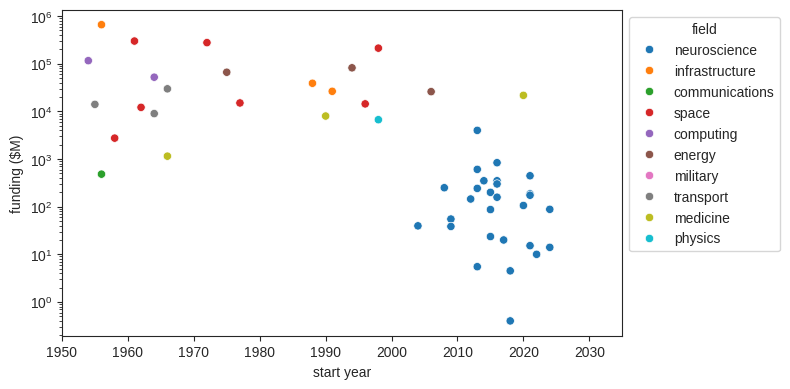

In [40]:
fig = plt.figure(figsize=(8,4))
ax = fig.subplots()

sns.scatterplot(
    all_proj_df,
    x='start year',
    y='funding ($M)',
    hue='field',
)

plt.yscale('log')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
# plt.ylim(1e0, 5e6)
plt.xlim(dt.datetime(year=1950, month=1, day=1), dt.datetime(year=2035, month=1, day=1))
plt.tight_layout()
add_attribution()
# plt.savefig('second-drafts/initiatives5.png')

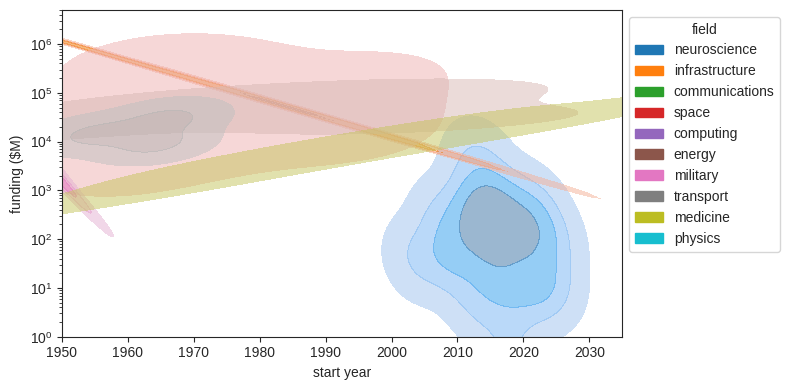

In [41]:
fig = plt.figure(figsize=(8,4))
ax = fig.subplots()

sns.kdeplot(
    all_proj_df,
    x='start year',
    y='funding ($M)',
    hue='field',
    log_scale=(False, True),
    fill=True,
    alpha=0.5,
    warn_singular=False,
    levels=5
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.ylim(1e0, 5e6)
plt.xlim(dt.datetime(year=1950, month=1, day=1), dt.datetime(year=2035, month=1, day=1))
plt.tight_layout()
add_attribution()
# plt.savefig('second-drafts/initiatives5.png')

In [42]:
all_proj_df['end year']

0    2024-12-31
1    2024-12-31
2    2023-01-01
3    2024-12-31
4    2024-12-31
5    2024-12-31
6    2024-12-31
7    2024-12-31
8    2024-01-01
9    2024-12-31
10   2024-12-31
11   2024-12-31
12   2024-12-31
13   2024-12-31
14   2024-12-31
15   2024-12-31
16   2024-12-31
17   2024-12-31
18   2024-12-31
19   2014-01-01
20   2024-12-31
21   2024-12-31
22   2024-12-31
23   2024-12-31
24   2024-12-31
25   2017-01-01
26   2024-12-31
27   2023-01-01
28   1992-01-01
29   1978-01-01
30   1975-01-01
31   2011-01-01
32   2011-01-01
33   1983-01-01
34   2012-01-01
35   1977-01-01
36   1946-01-01
37   1978-01-01
38   1994-01-01
39   1946-01-01
40   2023-01-01
41   2007-01-01
42   2025-01-01
43   2021-01-01
44   1990-01-01
45   2021-01-01
46   1979-01-01
47   1942-01-01
48   1966-01-01
49   1972-01-01
50   2003-01-01
51   2008-01-01
52   1949-01-01
53   1963-01-01
54   1980-01-01
Name: end year, dtype: datetime64[ns]

In [43]:
proj_durations = all_proj_df['end year'] - all_proj_df['start year']
proj_midpoints = all_proj_df['start year'] + proj_durations / 2
all_proj_df['midpoint'] = proj_midpoints

In [44]:
proj_categories = all_proj_df['field'].unique()
category_colors = [f'C{i}' for i in range(len(proj_categories))]

category_colormap = dict(zip(proj_categories, category_colors))
category_colormap

{'neuroscience': 'C0',
 'infrastructure': 'C1',
 'communications': 'C2',
 'space': 'C3',
 'computing': 'C4',
 'energy': 'C5',
 'military': 'C6',
 'transport': 'C7',
 'medicine': 'C8',
 'physics': 'C9'}

In [45]:
proj_colors = list(map(lambda cat: category_colormap[cat], all_proj_df['field']))

In [46]:
len(other_proj_df.dropna(subset=['start year', 'end year', 'funding ($M)']))

27

In [47]:
len(brain_proj_df.dropna(subset=['start year', 'end year', 'funding ($M)']))

28

In [48]:
len(all_proj_df)

55

In [49]:
import matplotlib.dates as mdates

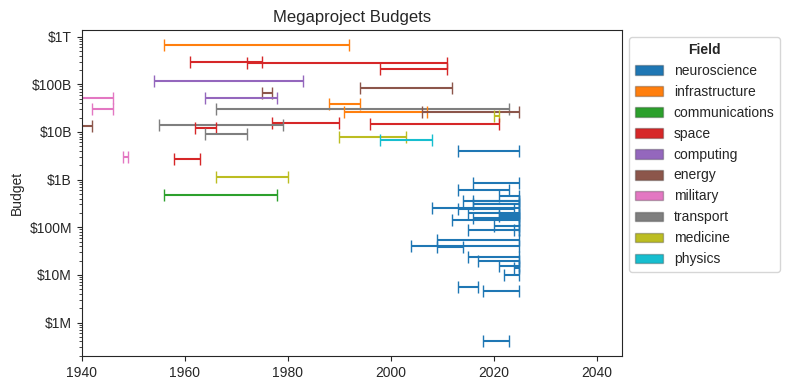

In [50]:
fig, ax = plt.subplots(figsize=(8, 4))

for j, (i, row) in enumerate(all_proj_df.iterrows()):
    plt.errorbar(
        [proj_midpoints[i]],
        [1e6 * row['funding ($M)']],
        ls='none',
        xerr=[proj_durations[i] / 2],
        capsize=4,
        ecolor=proj_colors[j],
    )
plt.yscale('log')
plt.xlim(dt.datetime(year=1940, month=1, day=1), dt.datetime(year=2045, month=1, day=1))
# plt.xlim(dt.datetime(year=1980, month=1, day=1), dt.datetime(year=2035, month=1, day=1))
plt.ylabel('Budget')


legend_handles = [
    Patch(
        facecolor=color,
        edgecolor=COLOR_PALETTE['dividers'],
        label=category
    ) 
    for category, color 
    in zip(proj_categories, category_colors)
]

# for i, proj in all_proj_df.head(6).iterrows():
#     plt.text(
#         proj_midpoints[i],
#         1e6 * proj['funding ($M)'],
#         proj['project'],
#         ha='center',
#         va='bottom',
#     )

plt.yticks([1e6, 1e7, 1e8, 1e9, 1e10, 1e11, 1e12], labels=['$1M', '$10M', '$100M', '$1B', '$10B', '$100B', '$1T'])
plt.legend(handles=legend_handles, title="field", loc='upper left', bbox_to_anchor=(1,1))
plt.title('Megaproject Budgets')

# Convert log-scale values to figure coordinates
def log_to_figure_y(y_value):
    return ax.transData.transform([0, np.log10(y_value)])[1]

# Add Ellipse for "Potential Projects"
center_x = dt.datetime(year=2030, month=1, day=1) # Middle of x-axis
center_y = 5e8  # Center around 500 million
width_x = dt.timedelta(days=10*365)  # Approximately ten years wide
width_y = 5e8  # Spanning from 1M to 100B on log scale

trans = ax.transData + fig.transFigure.inverted()

# ellipse_xy = (0.7, 0.6)

# # Create an Ellipse patch in figure coordinates
# # Parameters: (x, y, width, height) in figure coordinates
# # The x, y are the center of the ellipse
# ellipse = Ellipse(xy=ellipse_xy,  # Center at the middle of the figure
#                   width=0.15,       # Width of the ellipse (fraction of figure width)
#                   height=0.35,      # Height of the ellipse (fraction of figure height)
#                   # angle=-45,        # Rotation angle in degrees
#                   alpha=0.8,       # Transparency
#                   facecolor=COLOR_PALETTE['deepsky-blue'],
#                   # facecolor='green',
#                   edgecolor=COLOR_PALETTE['bittersweet'],
#                   linewidth=2,
#                   zorder=2,
#                   transform=fig.transFigure)  # Use figure coordinates

# # Add the ellipse to the figure (not to the axis)
# ax.add_patch(ellipse)

# plt.text(
#     *ellipse_xy, 
#     'Potential\nBrain Emulation\nProjects', 
#     ha='center', 
#     va='center', 
#     fontdict={'size': 11, 'linespacing': 1.5},
#     transform=fig.transFigure
# )



# fig.patches.append([
#     # Ellipse((dt.datetime(year=2030, month=1, day=1), 2e8), dt.timedelta(days=10*365), 1e7, transform=ax.transData)
#     Ellipse((0.5, 0.5), 0.2, 0.4)
# ])

leg = ax.get_legend()
leg.set_title('Field', prop={'weight': 'bold'})

plt.tight_layout()
add_attribution()
plt.savefig('fifth-drafts/funding.svg')
plt.show()

In [51]:
from matplotlib.patches import Ellipse

In [52]:
all_proj_df['midpoint'] = proj_midpoints

<Axes: xlabel='midpoint', ylabel='funding ($M)'>

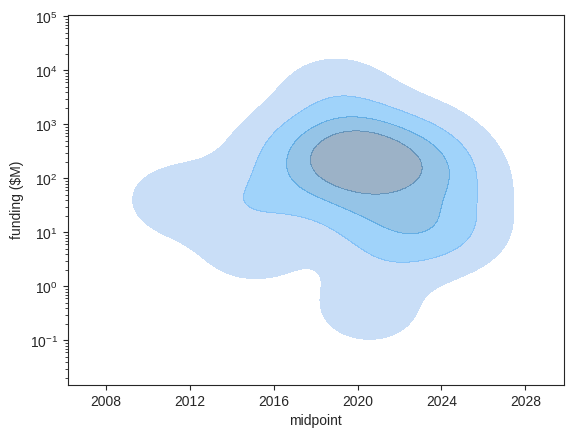

In [53]:
sns.kdeplot(
    all_proj_df[all_proj_df['field'] == 'neuroscience'],
    x='midpoint',
    y='funding ($M)',
    hue='field',
    legend=False,
    log_scale=(False, True),
    fill=True,
    alpha=0.5,
    warn_singular=False,
    levels=5,
)


In [54]:
all_proj_df[all_proj_df['field'] == 'neuroscience']

,project,funding ($M),field,start year,end year,midpoint
0,Brain Research Through Advancing Innovative Ne...,4000.0,neuroscience,2013-01-01,2024-12-31,2019-01-01 00:00:00
1,Neuralink,838.0,neuroscience,2016-01-01,2024-12-31,2020-07-01 12:00:00
2,Human Brain Project (HBP),607.0,neuroscience,2013-01-01,2023-01-01,2018-01-01 00:00:00
3,China Brain Project (CBP),446.0,neuroscience,2021-01-01,2024-12-31,2023-01-01 00:00:00
4,Adolescent Brain Development (ABCD) study,350.0,neuroscience,2016-01-01,2024-12-31,2020-07-01 12:00:00
5,Brain Mapping by Integrated Neurotechnologies ...,350.0,neuroscience,2014-01-01,2024-12-31,2019-07-02 12:00:00
6,Allen Institute for Brain Science,300.0,neuroscience,2016-01-01,2024-12-31,2020-07-01 12:00:00
7,BlackRock Neurotech,250.0,neuroscience,2008-01-01,2024-12-31,2016-07-01 12:00:00
8,Blue Brain Project,242.0,neuroscience,2013-01-01,2024-01-01,2018-07-02 12:00:00
9,BrainCo,200.0,neuroscience,2015-01-01,2024-12-31,2020-01-01 00:00:00


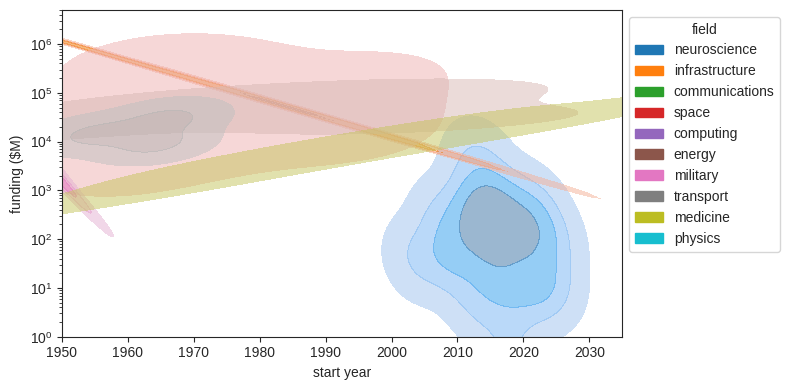

In [55]:
fig = plt.figure(figsize=(8,4))
ax = fig.subplots()

sns.kdeplot(
    all_proj_df,
    x='start year',
    y='funding ($M)',
    hue='field',
    log_scale=(False, True),
    fill=True,
    alpha=0.5,
    warn_singular=False,
    levels=5
)
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1))
plt.ylim(1e0, 5e6)
plt.xlim(dt.datetime(year=1950, month=1, day=1), dt.datetime(year=2035, month=1, day=1))
plt.tight_layout()
add_attribution()
# plt.savefig('second-drafts/initiatives5.png')

# Organism Compute (Parallel Cordinates)

In [56]:
systems_df = pd.read_csv('./data/organism-compute-3d/Compute visualization - Systems.csv', nrows=6)

systems_df

,System,Unnamed: 1,Max compute FLOPS / s (FP16 (Half Precision)),Max Storage Bytes,Max Interconnect (bits / s),Unnamed: 5,Unnamed: 6
0,MacBook Pro 2024 M4 Pro,2024,3.400000e+13,1.300000e+11,5.500000e+11,https://www.apple.com/macbook-pro/specs/,https://www.cpu-monkey.com/en/igpu-apple_m4_ma...
1,MacStudio M2 Ultra,2023,5.400000e+13,1.900000e+11,8.000000e+11,https://www.apple.com/shop/buy-mac/mac-studio/...,https://www.cpu-monkey.com/en/igpu-apple_m2_ul...
2,NVIDIA A100 SXM,2020,6.200000e+14,8.000000e+10,6.000000e+11,https://www.nvidia.com/content/dam/en-zz/Solut...,NaN
3,NVIDIA H100 NVL,2023,1.700000e+15,9.400000e+10,3.900000e+12,https://www.nvidia.com/en-sg/data-center/h100/,NaN
4,NVIDA DGX GH200,2023,2.000000e+18,1.400000e+14,9.000000e+11,https://nvidianews.nvidia.com/news/nvidia-anno...,NaN
5,NVIDIA HGX B200,2024,3.600000e+16,1.500000e+12,1.400000e+13,https://www.nvidia.com/en-sg/data-center/hgx/,NaN


In [57]:
systems_df['Class'] = 'One'

In [58]:
points_df = systems_df.rename(
    columns={
        'Max compute FLOPS / s (FP16 (Half Precision))': 'Compute\n(FLOP / s)',
        'Max Storage Bytes': 'Storage\n(bytes)',
        'Max Interconnect (bits / s)': 'Interconnect\n(bits / s)',
    }
)

In [59]:
renaming = {
    'Max compute FLOPS / s (FP16 (Half Precision))': 'x',
    'Max Storage Bytes': 'y',
    'Max Interconnect (bits / s)': 'z',
    'System': 'label',
}
points_df = systems_df.rename(
    columns=renaming,
)[list(renaming.values())]


points_df

,x,y,z,label
0,3.400000e+13,1.300000e+11,5.500000e+11,MacBook Pro 2024 M4 Pro
1,5.400000e+13,1.900000e+11,8.000000e+11,MacStudio M2 Ultra
2,6.200000e+14,8.000000e+10,6.000000e+11,NVIDIA A100 SXM
3,1.700000e+15,9.400000e+10,3.900000e+12,NVIDIA H100 NVL
4,2.000000e+18,1.400000e+14,9.000000e+11,NVIDA DGX GH200
5,3.600000e+16,1.500000e+12,1.400000e+13,NVIDIA HGX B200


In [60]:
organisms_df = pd.read_csv('./data/organism-compute-3d/Compute visualization - Organism boundaries.csv')
organisms_df

,Organism,Min Compute FLOPS/s,Max compute FLOPS / s,Min Storage Bytes,Max Storage Bytes,Min Interconnect Bits/s,Max Interconnect
0,C.elegans,1.000000e+06,1.000000e+08,1.000000e+06,1.000000e+07,1.000000e+09,1.000000e+10
1,Fruitfly,1.000000e+08,1.000000e+13,1.000000e+08,1.000000e+10,1.000000e+09,1.000000e+11
2,Zebrafish larvae,1.000000e+08,1.000000e+13,1.000000e+08,1.000000e+10,1.000000e+09,1.000000e+11
3,Mouse,1.000000e+14,1.000000e+19,1.000000e+11,1.000000e+13,1.000000e+10,1.000000e+12
4,Human,1.000000e+17,1.000000e+22,1.000000e+13,1.000000e+16,1.000000e+11,1.000000e+13


In [61]:
regions_df = organisms_df.rename(
    columns={
        'Organism': 'label',
        'Min Compute FLOPS/s': 'x_min',
        'Max compute FLOPS / s': 'x_max',
        'Min Storage Bytes': 'y_min',
        'Max Storage Bytes': 'y_max',
        'Min Interconnect Bits/s': 'z_min',
        'Max Interconnect': 'z_max',
    }
)
regions_df.drop(2, inplace=True)
regions_df.reset_index(inplace=True, drop=True)
regions_df

,label,x_min,x_max,y_min,y_max,z_min,z_max
0,C.elegans,1.000000e+06,1.000000e+08,1.000000e+06,1.000000e+07,1.000000e+09,1.000000e+10
1,Fruitfly,1.000000e+08,1.000000e+13,1.000000e+08,1.000000e+10,1.000000e+09,1.000000e+11
2,Mouse,1.000000e+14,1.000000e+19,1.000000e+11,1.000000e+13,1.000000e+10,1.000000e+12
3,Human,1.000000e+17,1.000000e+22,1.000000e+13,1.000000e+16,1.000000e+11,1.000000e+13


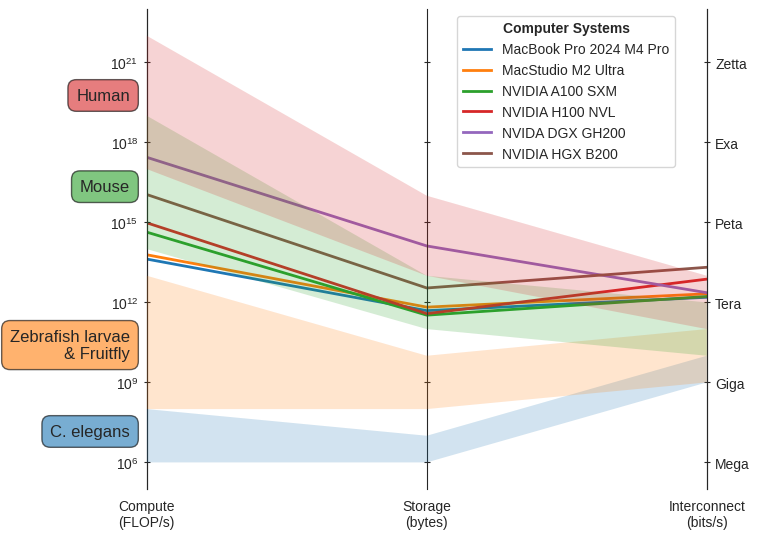

In [66]:
# Ensure min is less than max
regions_df[['x_min', 'x_max']] = np.sort(regions_df[['x_min', 'x_max']].values, axis=1)
regions_df[['y_min', 'y_max']] = np.sort(regions_df[['y_min', 'y_max']].values, axis=1)
regions_df[['z_min', 'z_max']] = np.sort(regions_df[['z_min', 'z_max']].values, axis=1)

# Combine all values to determine the scales
x_vals = np.concatenate([points_df['x'], regions_df['x_min'], regions_df['x_max']])
y_vals = np.concatenate([points_df['y'], regions_df['y_min'], regions_df['y_max']])
z_vals = np.concatenate([points_df['z'], regions_df['z_min'], regions_df['z_max']])

# Build the figure
fig = plt.figure(figsize=(8, 6))

# Create main axes occupying the full figure (invisible)
main_ax = fig.add_axes([0.2, 0.1, 0.7, 0.8])
# main_ax = fig.add_axes([0, 0, 1, 1])
# main_ax.set_xticks([])
main_ax.set_yticks([])
# main_ax.axis('off')
main_ax.set_xlim([0, 1])
main_ax.set_ylim([0, 1])

# Positions for the axes (normalized figure coordinates)
x_positions = [0.2, 0.55, 0.9]  # x positions of the axes

axis_labels = ['Compute\n(FLOP/s)', 'Storage\n(bytes)', 'Interconnect\n(bits/s)']
main_ax.set_xticks([0, 0.5, 1])
main_ax.set_xticklabels(axis_labels)
main_ax.spines['top'].set_visible(False)
main_ax.spines['bottom'].set_visible(False)
main_ax.xaxis.set_tick_params(width=0)

# Width of each individual axis
axis_width = 0.0  # Width of the axes in figure coordinates

# Create axes for x, y, z at specified positions
ax_x = fig.add_axes([x_positions[0] - axis_width / 2, 0.1, axis_width, 0.8])
ax_y = fig.add_axes([x_positions[1] - axis_width / 2, 0.1, axis_width, 0.8])
ax_z = fig.add_axes([x_positions[2] - axis_width / 2, 0.1, axis_width, 0.8])

# Set y-scales to logarithmic
ax_x.set_yscale('log')
ax_y.set_yscale('log')
ax_z.set_yscale('log')

# uniform scale for all axes
ax_x.set_ylim([1e5, 1e23])
ax_y.set_ylim([1e5, 1e23])
ax_z.set_ylim([1e5, 1e23])

# Remove x-ticks and labels
for ax in [ax_x, ax_y, ax_z]:
    ax.set_xticks([])
    ax.set_xticklabels([])
    ax.tick_params(axis='x', which='both', length=0)
    ax.tick_params(axis='y', which='both', direction='inout', length=5)
    # Remove unnecessary spines
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    # ax.spines['left'].set_visible(False)

    ax.yaxis.set_major_locator(mticker.LogLocator(base=1000.0, numticks=10))

# Function to plot the lines for points
def plot_point(row):
    # Get data values
    y_x, y_y, y_z = row['x'], row['y'], row['z']
    label = row['label'] if 'label' in row else None
    # Map them to display coordinates
    x_disp = [0, 0.5, 1]
    y_disp = []
    for ax, y_val in zip([ax_x, ax_y, ax_z], [y_x, y_y, y_z]):
        trans = ax.transData.transform((0, y_val))
        inv = fig.transFigure.inverted().transform(trans)
        y_disp.append(inv[1])
    # Plot the line in figure coordinates
    main_ax.plot(
        x_disp, 
        y_disp, 
        # color='blue', 
        lw=2,
        label=label
    )

# Plot data points
points_df.apply(plot_point, axis=1)

region_alpha = 0.2

data_ticks = [1e6, 1e9, 1e12, 1e15, 1e18, 1e21]
ticklabels = ['Mega', 'Giga', 'Tera', 'Peta', 'Exa', 'Zetta']

ax_y.yaxis.set_ticklabels([])
ax_z.yaxis.tick_right()
ax_z.yaxis.set_ticks(data_ticks, ticklabels)

# Function to plot the regions
def plot_region(row):
    # Get min and max values for each axis
    y_x_min, y_x_max = row['x_min'], row['x_max']
    y_y_min, y_y_max = row['y_min'], row['y_max']
    y_z_min, y_z_max = row['z_min'], row['z_max']
    
    label = row['label'] if 'label' in row else None
        
    # Map min and max values to display coordinates
    coords_min = []
    coords_max = []
    for ax, y_min, y_max, x_pos in zip(
        [ax_x, ax_y, ax_z],
        [y_x_min, y_y_min, y_z_min],
        [y_x_max, y_y_max, y_z_max],
        x_positions,
    ):
        trans_min = ax.transData.transform((0, y_min))
        trans_max = ax.transData.transform((0, y_max))
        inv_min = fig.transFigure.inverted().transform(trans_min)
        inv_max = fig.transFigure.inverted().transform(trans_max)
        coords_min.append((x_pos, inv_min[1]))
        coords_max.append((x_pos, inv_max[1]))
    # Create polygon points
    polygon_points = coords_min + coords_max[::-1]
    color = f'C{row.name}'
    polygon = Polygon(
        polygon_points,
        closed=True,
        # facecolor='red',
        facecolor=color,
        alpha=region_alpha,
        edgecolor=None,
        # label=label,
        transform=fig.transFigure,
    )
    fig.patches.append(polygon)

legend_patches = []

# Plot regions
regions_df.apply(plot_region, axis=1)

label_xpos = -0.03
# Draw region labels
organism_labels = [
    ('C. elegans', label_xpos, 0.12),
    ('Zebrafish larvae\n& Fruitfly', label_xpos, 0.3),
    ('Mouse', label_xpos, 0.63),
    ('Human', label_xpos, 0.82),
]

for i, (text, x, y) in enumerate(organism_labels):
    color = f'C{i}'
    main_ax.text(x, y, text,
         ha='right', va='center', fontsize=12,
         bbox=dict(facecolor=color, alpha=0.6, edgecolor='black', boxstyle='round,pad=0.5'))




plt.sca(main_ax)
plt.legend(
    loc='upper right',
    bbox_to_anchor=(0.955,1), 
    title=r'Computer Systems',
    title_fontproperties={'weight': 'bold'}
)

# plt.tight_layout()
add_attribution()
plt.savefig('fifth-drafts/organism-compute.svg')
plt.show()